import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and main axis
fig, ax = plt.subplots(figsize=(12, 8))

# Non-Workday KDE (blues)
kde_nonworkday = sns.kdeplot(
    data=daily_counts[daily_counts['workingday'] == 'no'],
    x='casual',
    y='registered',
    fill=True,
    cmap='Blues',
    thresh=0,
    levels=80,  # Adjusted levels for better visibility
    alpha=0.7,   # Reduced alpha to make red gradient more visible
    ax=ax
)

# Workday KDE (reds)
kde_workday = sns.kdeplot(
    data=daily_counts[daily_counts['workingday'] == 'yes'],
    x='casual',
    y='registered',
    fill=True,
    cmap='Reds',
    thresh=0,
    levels=80,  # Adjusted levels for better visibility
    alpha=0.9,   # Increased alpha for stronger visibility
    ax=ax
)

# Add colorbar for Non-Workday KDE plot
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cb1 = plt.colorbar(kde_nonworkday.collections[0], cax=cax1)
cb1.set_label('Non-Workday Density')

# Add colorbar for Workday KDE plot
cax2 = divider.append_axes("right", size="5%", pad=0.1)
cb2 = plt.colorbar(kde_workday.collections[0], cax=cax2)
cb2.set_label('Workday Density')

# Custom legend
workday_patch = mpatches.Patch(color='salmon', label='Workday')
nonworkday_patch = mpatches.Patch(color='skyblue', label='Non-Workday')
plt.legend(handles=[workday_patch, nonworkday_patch], title='workingday')

# Titles and labels
ax.set_title('Bivariate KDE Plot Comparison of Registered vs Casual Riders')
ax.set_xlabel('casual')
ax.set_ylabel('registered')

plt.tight_layout()
plt.show()

## Introduction

Bike-sharing systems are a new generation of traditional bike rentals where the process of signing up, renting, and returning is automated. Through these systems, users are able to easily rent a bike from one location and return them to another. I will be analyzing bike-sharing data from Washington, DC. 

I will clean, visualize, and explore the bike-sharing data. I will also investigate how the plots created provide insight into the data.

* Reading plain text delimited data into `pandas`,
* Wrangling data for analysis,
* Using EDA to learn about your data, and 
* Making informative plots.

In [23]:
# Import necessary libraries
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from pathlib import Path
import ds100_utils

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()
sns.set_theme(rc={"figure.figsize": (16, 8)})

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Latex, Markdown

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Loading Bike Sharing Data
The data is collected from a bike-sharing system in Washington, DC.

The variables in this `DataFrame` are defined as:

Variable       | Description
-------------- | ------------------------------------------------------------------
instant | record index
dteday | date
season | 1. spring <br> 2. summer <br> 3. fall <br> 4. winter
yr | year (0: 2011, 1:2012)
mnth | month ( 1 to 12)
hr | hour (0 to 23)
holiday | whether the day is a holiday or not
weekday | day of the week
workingday | if the day is neither a weekend nor a holiday
weathersit | 1. clear or partly cloudy <br> 2. mist and clouds <br> 3. light snow or rain <br> 4. heavy rain or snow
temp | normalized temperature in Celsius (divided by 41)
atemp | normalized "feels-like" temperature in Celsius (divided by 50)
hum | normalized percent humidity (divided by 100)
windspeed| normalized wind speed (divided by 67)
casual | count of casual users
registered | count of registered users
cnt | count of total rental bikes, including casual and registered  

### Download the Data

In [24]:
# Download the data
data_url = 'https://github.com/DS-100/fa20/raw/gh-pages/resources/assets/datasets/hw3-bikeshare.zip'
file_name = 'data.zip'
data_dir = 'data/'

dest_path = ds100_utils.fetch_and_cache(data_url=data_url, data_dir=data_dir, file=file_name)
print('Saved at {}'.format(dest_path))

zipped_data = zipfile.ZipFile(dest_path, 'r')

data_dir = Path('data')
zipped_data.extractall(data_dir)


print("Extracted Files:")
for f in data_dir.glob("*"):
    print("\t",f)

Using version already downloaded: Tue Jul 15 16:41:08 2025
MD5 hash of file: 2bcd2ca89278a8230f4e9461455c0811
Saved at data\data.zip
Extracted Files:
	 data\bikeshare.txt
	 data\data.zip


### Examining the File Contents

In [25]:
# Look at the top of the file
for line in ds100_utils.head(data_dir/'bikeshare.txt'):
    print(line,end="")

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13


### Size
Is the file big?  How many records is expected?

In [26]:
# View metadata
print("Size:", (data_dir/"bikeshare.txt").stat().st_size, "bytes")
print("Line Count:", ds100_utils.line_count(data_dir/"bikeshare.txt"), "lines")

Size: 1156736 bytes
Line Count: 17380 lines


### Loading the Data

The following code loads the data into the `bike` `DataFrame`.

In [27]:
# Load data into a DataFrame
bike = pd.read_csv(data_dir/'bikeshare.txt')
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Below, I show the shape of the file. The size of the `DataFrame` matches the number of lines in the file minus the header row.

In [28]:
bike.shape

(17379, 17)

<hr style="border: 1px solid #fdb515;" />

## 1: Examining the Data

Before I start working with the data, I examine its granularity.

<br>

--- 
### 1(a) Granularity

Each row represents a record of bike-sharing usage information for each hour of the day from 2011 to 2012. 

In [29]:
bike.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


<br>

--- 
### 1(b) Data Limitations
This dataset offers useful insights into bike usage in Washington, DC, but it also has some notable limitations based on its current granularity and included variables.

One limitation is the absence of a location variable, which restricts the ability to analyze geographic patterns in bike-sharing activity. Including location data would allow for better understanding of where bike usage is concentrated and how it varies across neighborhoods. For example, the ratio of casual to registered users may differ substantially between commercial districts and residential areas. Location data could also help infer usage patterns, such as commuting from work to home or from a transit hub to an office, which would support more targeted expansion and allocation of bike-sharing infrastructure.

Another limitation lies in the categorization of users, particularly the distinction between “casual” and “registered” users. If “casual” simply refers to non-registered riders, the data may overcount occasional users. Some frequent riders may choose not to register, meaning they behave similarly to registered users but are misclassified. This compromises the accuracy of any analysis intended to understand user retention or long-term behavioral patterns.

Additionally, the normalized metrics in the dataset raise concerns. For instance, values labeled as "divided by 41" or "divided by 50" are unclear without further context. Including a descriptive column explaining the rationale behind these normalization choices would make the data more transparent and interpretable.

To address these limitations, two additional variables that would be useful to collect are:

1. Geographic location of bike pickups and drop-offs

2. User ID or anonymized identifiers to track ride frequency and behavior over time

<!-- END QUESTION -->



<hr style="border: 1px solid #fdb515;" />

## 2: Data Preparation

A few variables in the dataset, while stored as numeric or integer types, actually represent categorical information. These include `holiday`, `weekday`, `workingday`, and `weathersit`. To make the data more interpretable and suitable for analysis, I will convert these variables into categorical string values.

Specifically:

- For `weekday`, I will use three-letter abbreviations: `Sun`, `Mon`, `Tue`, `Wed`, `Thu`, `Fri`, and `Sat`.
- For both `holiday` and `workingday`, I will use the labels `yes` and `no`.
- For `weathersit`, I will convert the numeric values to descriptive strings based on their meanings (e.g., clear, cloudy, rainy), depending on the dataset's documentation.

This transformation will be done **in place**, meaning I will directly overwrite the existing columns in the `bike` DataFrame rather than creating a separate copy. This approach ensures that the changes are integrated into the data used throughout the rest of the project. I will also clearly document each transformation in the notebook to maintain transparency and reproducibility.

> **Note:** These changes only affect the in-memory version of the data and do not modify the original `bikeshare.txt` file.

<br>

---

### 2(a): Decoding `holiday`, `weekday`, `workingday`, and `weathersit`

In this step, I will decode the following fields to make them more readable and meaningful:

1. **`holiday`**: Convert numeric values to categorical values using `'yes'` and `'no'`.  
   *Note:* There are fewer holidays than non-holidays.

2. **`weekday`**: Replace the numeric values in the `'weekday'` column with three-letter abbreviations: `'Sun'`, `'Mon'`, `'Tue'`, `'Wed'`, `'Thu'`, `'Fri'`, and `'Sat'`.  
   Assume `0` corresponds to `'Sun'`, `1` to `'Mon'`, and so on, in order.

3. **`workingday`**: Similar to `holiday`, convert to `'yes'` and `'no'`.

4. **`weathersit`**: Map each numeric value to a descriptive label:
   - `1` → `'Clear'`
   - `2` → `'Mist'`
   - `3` → `'Light'`
   - `4` → `'Heavy'`

> **Note:** Mutating the DataFrame in this way will change its structure from the original `.csv` file.  
> If needed for debugging, rerun the cell that reloads the original file to revert these transformations.

My approach will use the [`DataFrame.replace`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) method from the `pandas` library to perform these transformations.

In [30]:
# Modify holiday weekday, workingday, and weathersit here.
holiday = {0: 'no', 1: 'yes'}
weekday = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
workingday = {0: 'no', 1: 'yes'}
weathersit = {1: 'Clear', 2: 'Mist', 3: 'Light', 4: 'Heavy'}
bike = bike.replace({'weekday': weekday, 'workingday' : workingday, 'holiday' : holiday, 'weathersit' : weathersit})
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,no,Sat,no,Clear,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,0,1,1


<br>

--- 
### 2(b) Counting Holidays
I determine how many entries in the `bike` DataFrame correspond to holidays.

I store the result in a variable called `num_holidays`, which will represent the total number of rows where the `holiday` column is equal to `'yes'`.

In [48]:
num_holidays = len(bike[bike['holiday'] == "yes"])
print(f"Number of Holidays: {num_holidays}")

Number of Holidays: 500


<br>

--- 
### 2(c) Computing Daily Total Counts
Now I will analyze the daily number of registered and unregistered users.

I construct a `DataFrame` named `daily_counts` indexed by `dteday` with the following columns:
* `casual`: total number of casual riders for each day.
* `registered`: total number of registered riders for each day.
* `workingday`: whether that day is a working day or not (`yes` or `no`).

In [49]:
daily_counts = bike.groupby('dteday').agg({'casual': 'sum', 'registered': 'sum', 'workingday': 'first'})
daily_counts.head()

,casual,registered,workingday
dteday,,,
2011-01-01,331,654,no
2011-01-02,131,670,no
2011-01-03,120,1229,yes
2011-01-04,108,1454,yes
2011-01-05,82,1518,yes


<hr style="border: 1px solid #fdb515;" />

## 3: Exploring the Distribution of Riders

To compare the distribution of daily counts between casual and registered riders, I will use a variety of visualization methods. 

For convenience, I have summarized a few useful options below that help illustrate distributional patterns effectively.

### Matplotlib and Seaborn Table of Common Functions

`x` and `y` are sequences of values (i.e., arrays, lists, or `Series`).

| Function | Description |
| -------- | ----------- |
| `plt.title(name)` | Adds a title `name` to the current plot. |
| `plt.xlabel(name)` | Adds a label `name` to the x-axis. |
| `plt.ylabel(name)` | Adds a label `name` to the y-axis. |
| `plt.plot(x, y)` | Creates a line plot of `x` against `y`. |
| `plt.scatter(x, y)` | Creates a scatter plot of `x` against `y`. |
| `plt.hist(x, bins=None)` | Creates a histogram of `x`; `bins` can be an integer or a sequence. |
| `plt.bar(x, height)` | Creates a bar plot of categories `x` and corresponding heights `height`. |
|`sns.histplot(data=, x=, y=, hue=, kde=)` | Creates a distribution plot; `data` is a `DataFrame`; `x`, `y` are column names in `data` that specify positions on the `x` and `y` axes; `hue` is a column name in `data` that adds subcategories to the plot based on `hue`; `kde` is a boolean that determines whether to overlay a KDE curve. |
|`sns.lineplot(data=, x=, y=, hue=)` | Creates a line plot. |
|`sns.scatterplot(data=, x=, y=, hue=, size=)` | Creates a scatter plot; `size` is a vector that contains the size of the point for each subcategory based on `hue`. |
|`sns.kdeplot(data=, x=, y=)` | Creates a kernel density estimate plot; `data` is a `DataFrame`; `x`, `y` are column names in `data` that specify positions on the `x` and `y` axes. |
|`sns.jointplot(data=, x=, y=, kind=)` | Creates a joint plot of 2 variables with a KDE plot in the middle and a distribution plot for each variable on the sides; `kind` determines the visualization type for the distribution plot, can be `scatter`, `kde` or `hist`. |

<br>

--- 
### 3(a) Visualizing Rider Distributions

To explore and compare the distributions of daily bike usage between casual and registered riders, I will use the [`sns.histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot) function from the Seaborn library.

Using the `daily_counts` DataFrame (constructed in 2c), I will create a plot that overlays the distribution of daily rider counts:

- **Casual riders** will be shown in **blue**.
- **Registered riders** will be shown in **green**.

> - Set the `stat` parameter appropriately to reflect a **density** plot or **count**, depending on how you want to compare the distributions.
> - Use the `label` parameter to clearly identify each distribution in the legend (e.g., `label="Casual"`).
> - Two separate calls to `sns.histplot` are needed. One for `casual`, one for `registered`.

The plot will also include:
- A **legend** to distinguish between the two rider types.
- Descriptive **x-axis** and **y-axis** labels.
- A clear and informative **title**.

> Once the plot is complete, I will review it to understand what the distributions reveal. For example, I might observe that on most days, the number of registered riders tends to peak around 4000, though it can vary between nearly 0 and 7000.

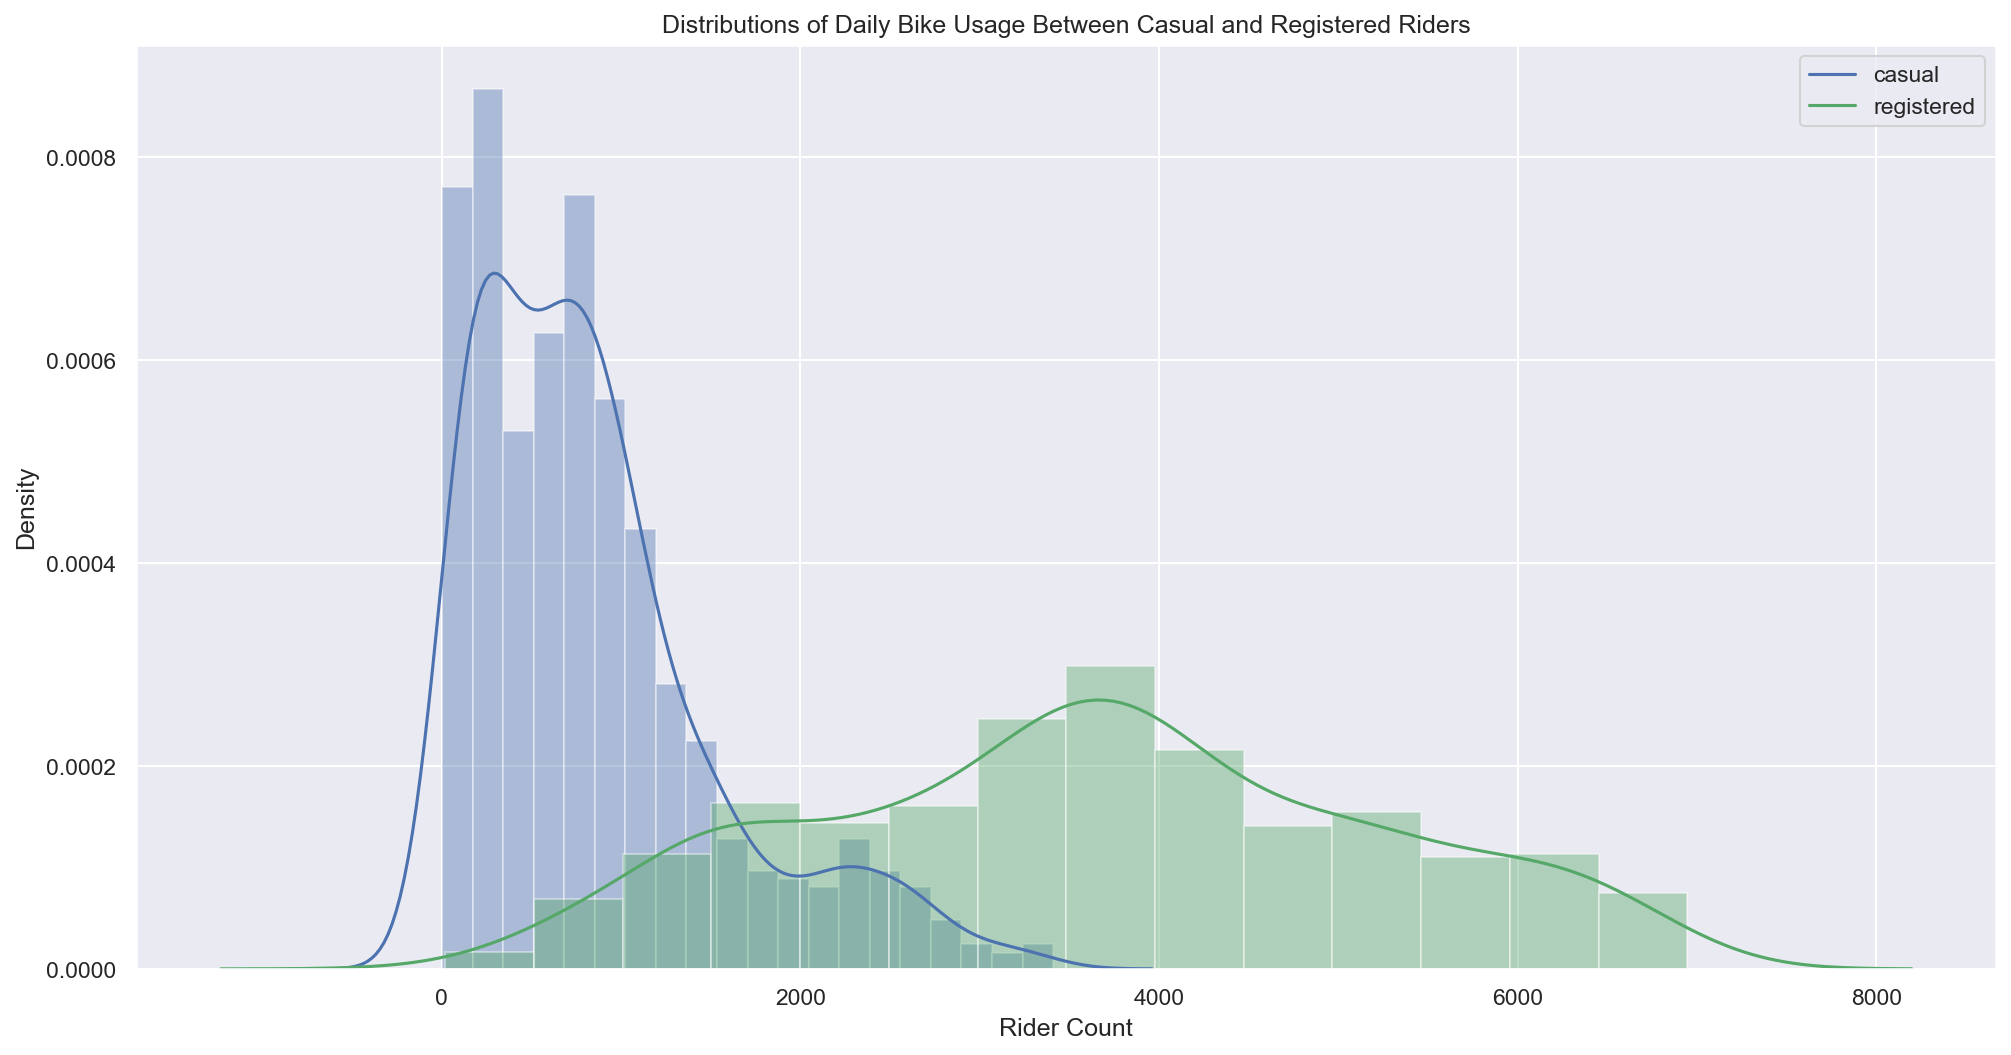

In [50]:
sns.distplot(daily_counts['casual'], color='b')
sns.distplot(daily_counts['registered'], color='g')
plt.title('Distributions of Daily Bike Usage Between Casual and Registered Riders')
plt.xlabel('Rider Count')
plt.ylabel('Density')
plt.legend(['casual', 'registered'])
plt.show()

<br>

--- 
### 3(b): Describing the Rider Distributions

To explore the usage behavior of casual and registered riders, I conducted a distributional analysis of their ride counts using density curves generated from histogram data. My goal was to compare the overall patterns in ride frequency and identify key behavioral distinctions between the two user groups.

I evaluated the following characteristics for each distribution:

- **Modes**: Identified the number and location of prominent peaks in the ride count distributions.
- **Symmetry**: Assessed whether the distributions were symmetrical or displayed noticeable skewness.
- **Skewness**: Determined the direction and extent to which the tails of each distribution stretched, indicating asymmetries in rider behavior.
- **Tails**: Observed the shape of the distribution tails to identify sharp drop-offs or extended ranges.
- **Gaps or Outliers**: Looked for any irregular breaks or extreme values that might signal anomalies or distinct subgroups.
- **Spread**: Measured the overall range and variability in ride counts to evaluate the consistency of usage within each group.

These descriptive elements provided insights into the differing usage patterns of casual and registered riders, offering a foundation for further behavioral or operational analysis.

The casual riders density curve center is higher than the registered riders curve and has a smaller spread in its distribution (likely meaning a smaller standard deviation). The latter curve is more symmetrical. The former curve has a left tail. It's not particularly clear what the mode is for the casual riders curve just by inspecting it visually, but the registered riders curve looks like it has a mode in the high 3000s.

<br>

--- 
### 3(c) Exploring the Relationship Between Casual and Registered Riders
To analyze how casual and registered rider counts vary together on an hourly basis, I created a scatter plot using Seaborn’s `lmplot`. This visualization reveals patterns in the relationship between the two rider types and how these patterns differ based on whether the day is a working day.

Using the hourly-level data from the `bike` DataFrame, I plotted:

- **X-axis**: Hourly casual rider counts  
- **Y-axis**: Hourly registered rider counts  
- **Hue**: Whether the day is a working day (colored accordingly)  
- **Regression Line**: Enabled to highlight the general trend in the data  

To improve readability given the large number of data points, I set smaller point sizes using the `scatter_kws` parameter. I also adjusted the plot size using the `height` parameter to ensure the visualization remains clean and interpretable.

This analysis provides insight into:

- Whether casual and registered ridership tend to increase together
- How workday patterns affect the relationship between the two rider types
- Potential differences in rider behavior on working vs. non-working days

The inclusion of regression lines further supports interpretation of the underlying trends, setting up a foundation for deeper exploration using linear modeling techniques.


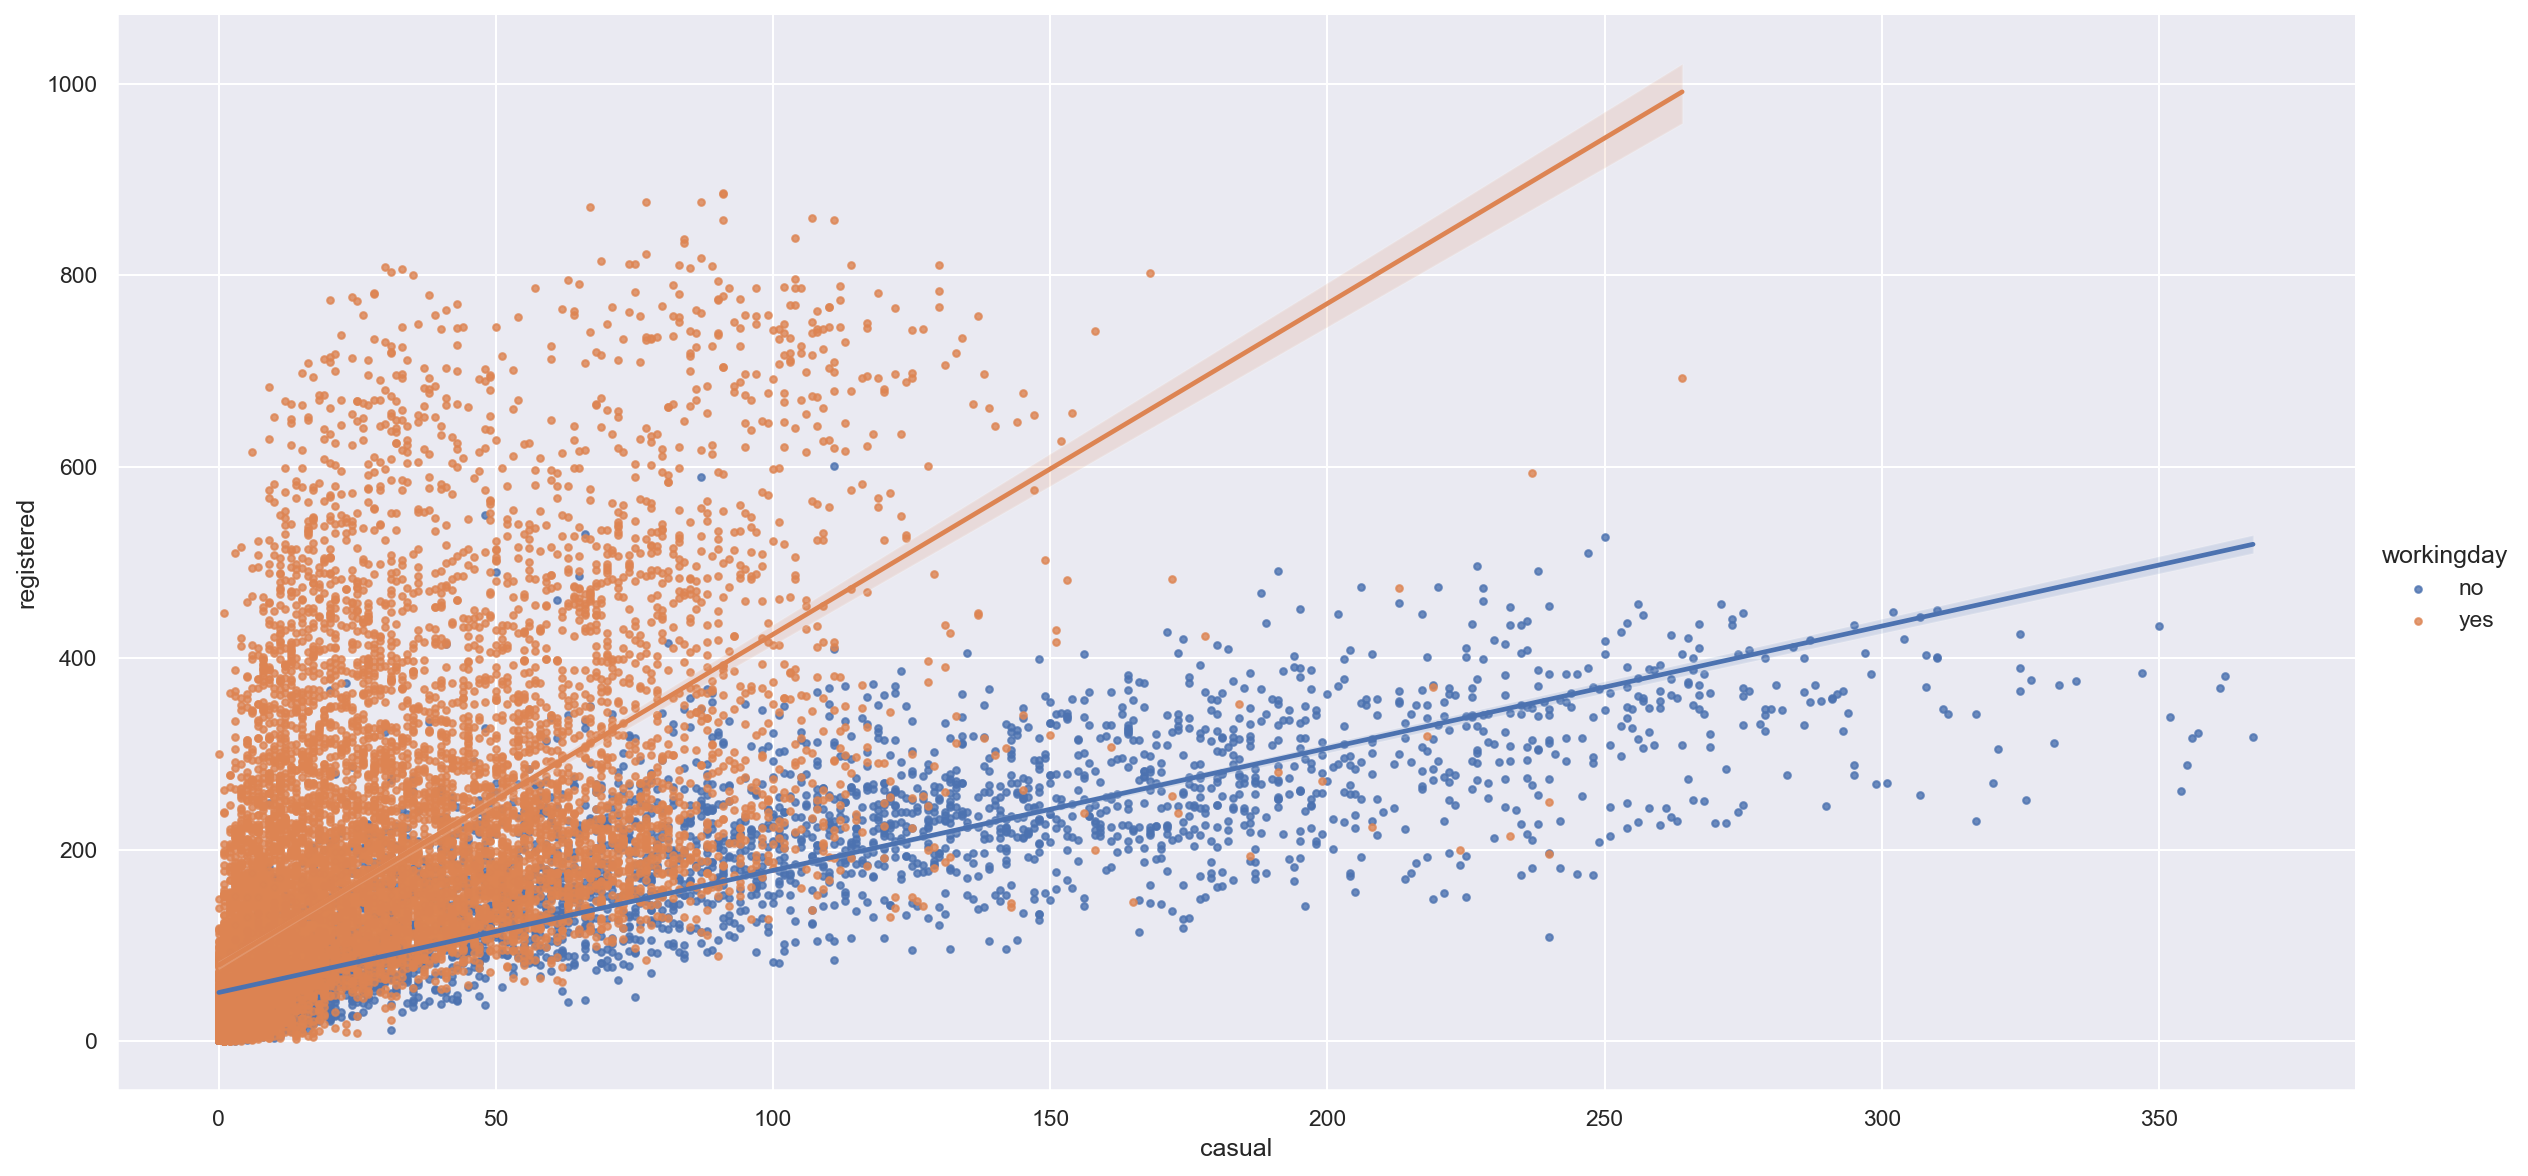

In [34]:
sns.set(font_scale=1)
g = sns.lmplot(x = 'casual', y = 'registered', data = bike, height = 8, aspect=2, hue = 'workingday', scatter_kws = {"s": 10})
plt.show();

<br>

--- 
### 3(d) Interpreting the Relationship Between Casual and Registered Riders

The scatter plot reveals a moderate positive relationship between casual and registered riders, with some notable variation depending on whether the day is a working day or a weekend:

- **Working Days**: Registered rider counts tend to be higher on working days, especially during peak commuting hours. The regression line for working days shows a stronger, more consistent upward trend, suggesting that registered riders are more active during the workweek.
  
- **Weekends/Non-Working Days**: Casual ridership appears more prominent on weekends. The relationship between casual and registered riders is weaker and more dispersed, with a broader spread of casual counts not strongly tied to registered activity.

However, **overplotting** poses a challenge in interpreting this relationship clearly. Because many data points occupy similar positions, especially in the lower ranges of casual and registered counts, it becomes difficult to distinguish density and variability in those regions. This makes it harder to assess the frequency or weight of specific behaviors.

To mitigate this, using transparency (`alpha`), smaller point sizes (`scatter_kws={'s': x}`), or even hexbin plots could improve visibility and support a more precise interpretation of trends.


There are more casual than registered riders on working days, and the contrary is true for non-working days. There exists overplotting in the bottom left of the scatter plot, which crowds the space visually and I cannot tell whether or not there is a pattern in relationships.

<hr style="border: 1px solid #fdb515;" />

## 4: Visualization
To reduce overplotting from the scatter plot, I used a **bivariate kernel density estimate (KDE)** with Seaborn’s `sns.kdeplot`. This technique highlights where casual and registered rider counts tend to cluster by smoothing the data into contour regions.

The KDE plot reveals:
- Clear density patterns not visible in the scatter plot
- Common combinations of casual and registered usage
- Better overall structure of rider behavior

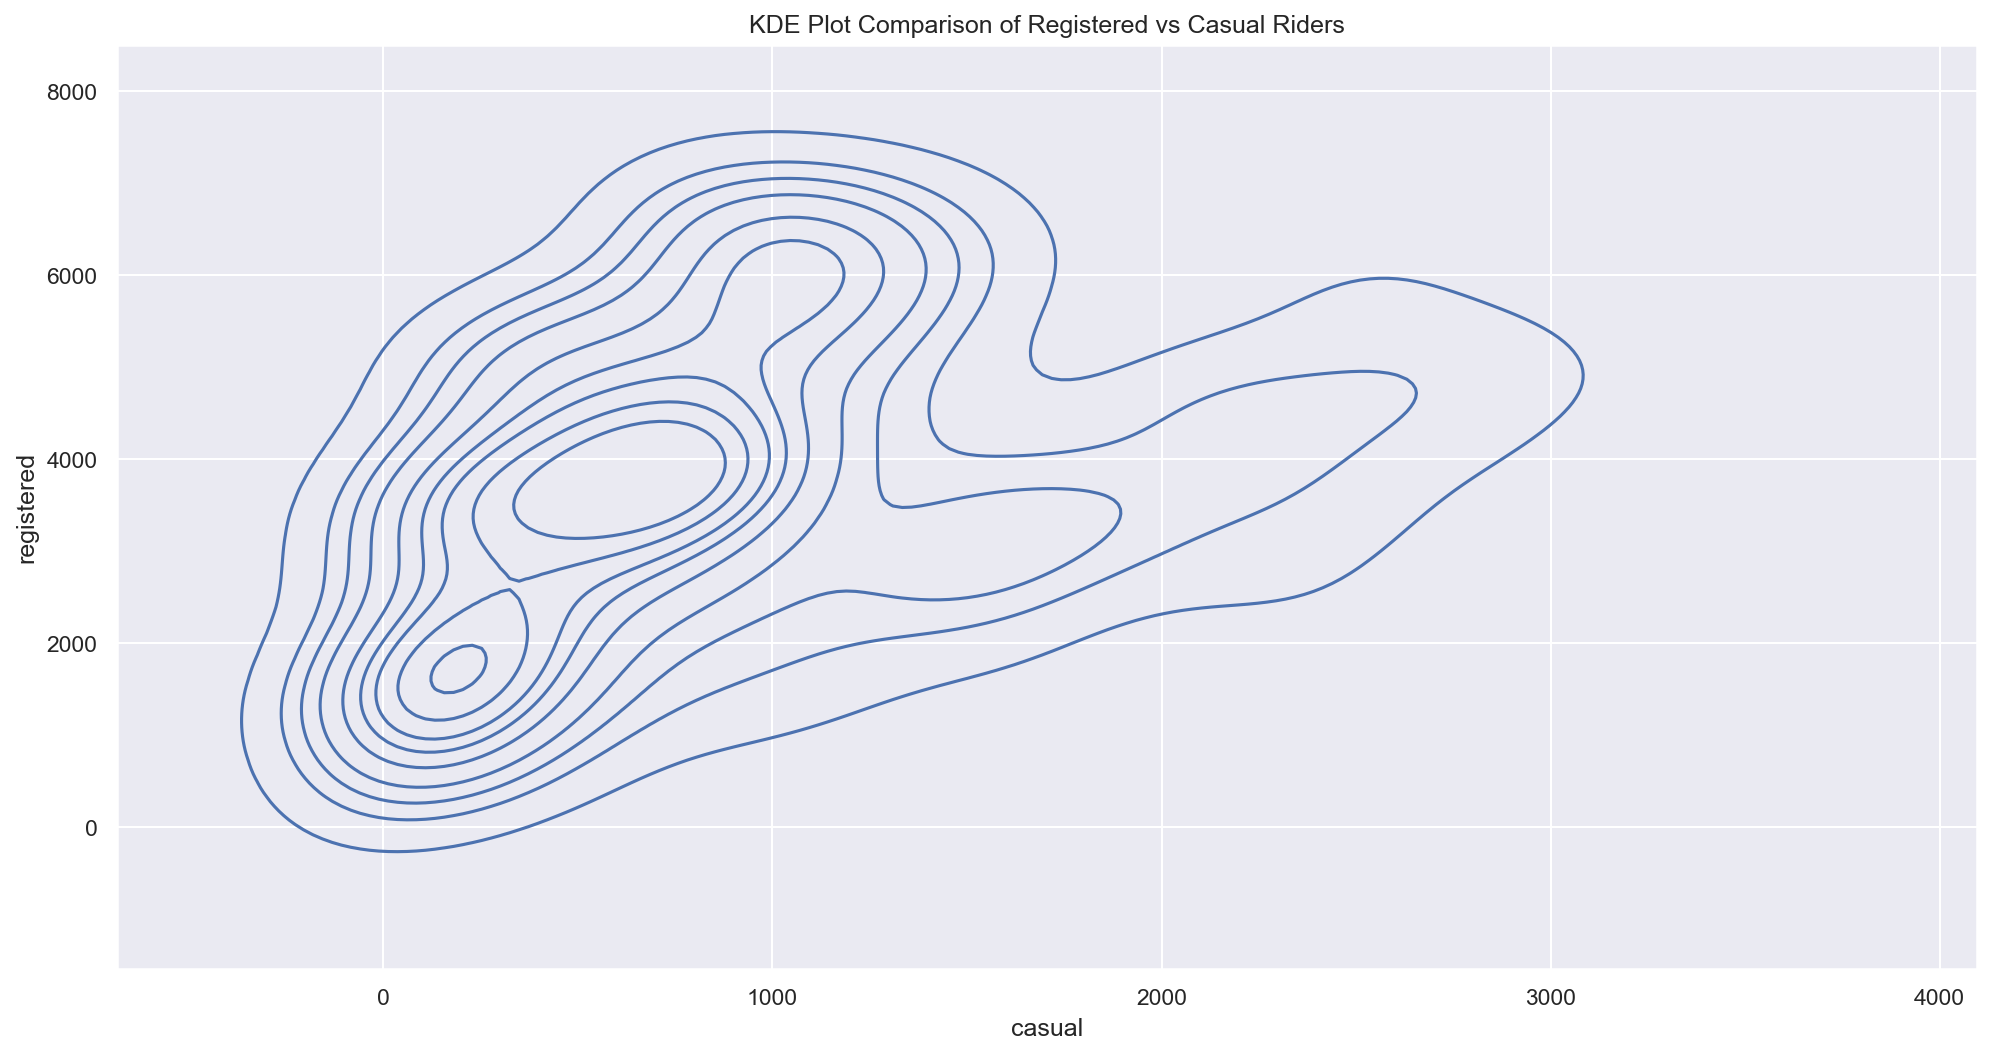

In [35]:
sns.kdeplot(data=daily_counts, x='casual', y='registered')
plt.title('KDE Plot Comparison of Registered vs Casual Riders');

A basic KDE plot of all the data (shown above) would combine both weekend and weekday data, which isn't what I need.

<br>

--- 

### 4(a) Bivariate Kernel Density Plot

## Comparing Rider Density by Workday Status

To examine how rider patterns differ between workdays and non-workdays, I used Seaborn’s `kdeplot` on the `daily_counts` DataFrame, setting `hue='workingday'` to separate the two categories.

The bivariate KDE plot visualizes the joint distribution of **casual** and **registered** rider counts, using contour lines to show density regions for each group. By setting `fill=False`, we keep the plot uncluttered and easier to compare across categories.

This approach clearly shows that:
- **Workdays** tend to have higher registered ridership and more concentrated usage.
- **Non-workdays** display greater variability in casual ridership with lower registered counts.

This plot helps highlight behavioral differences in rider types depending on the day type, which would have been harder to extract from raw scatter plots.

Text(0.5, 1.0, 'KDE Plots of Registered vs Casual Riders')

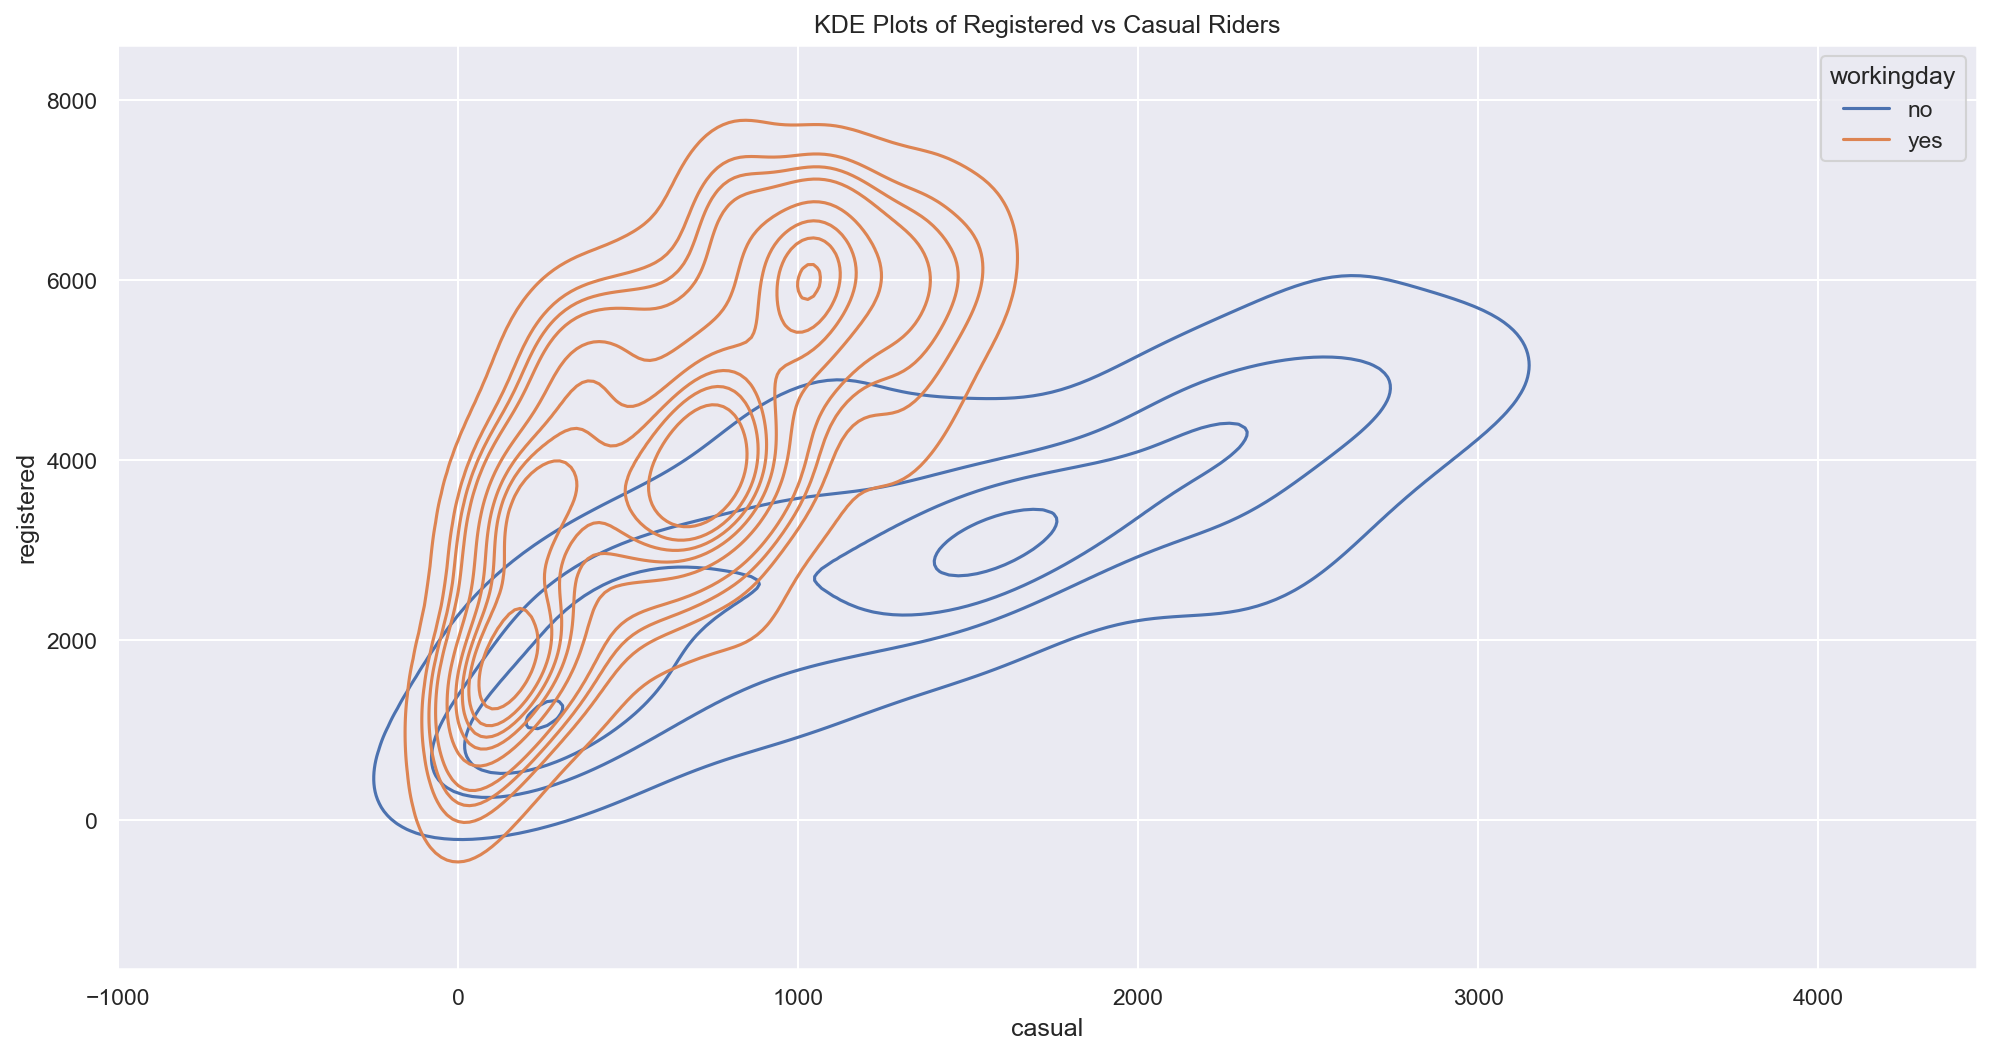

In [ ]:
sns.kdeplot(
    data=daily_counts,
    x='casual',
    y='registered',
    hue='workingday',
    fill=False)
plt.title('KDE Plots of Registered vs Casual Riders')

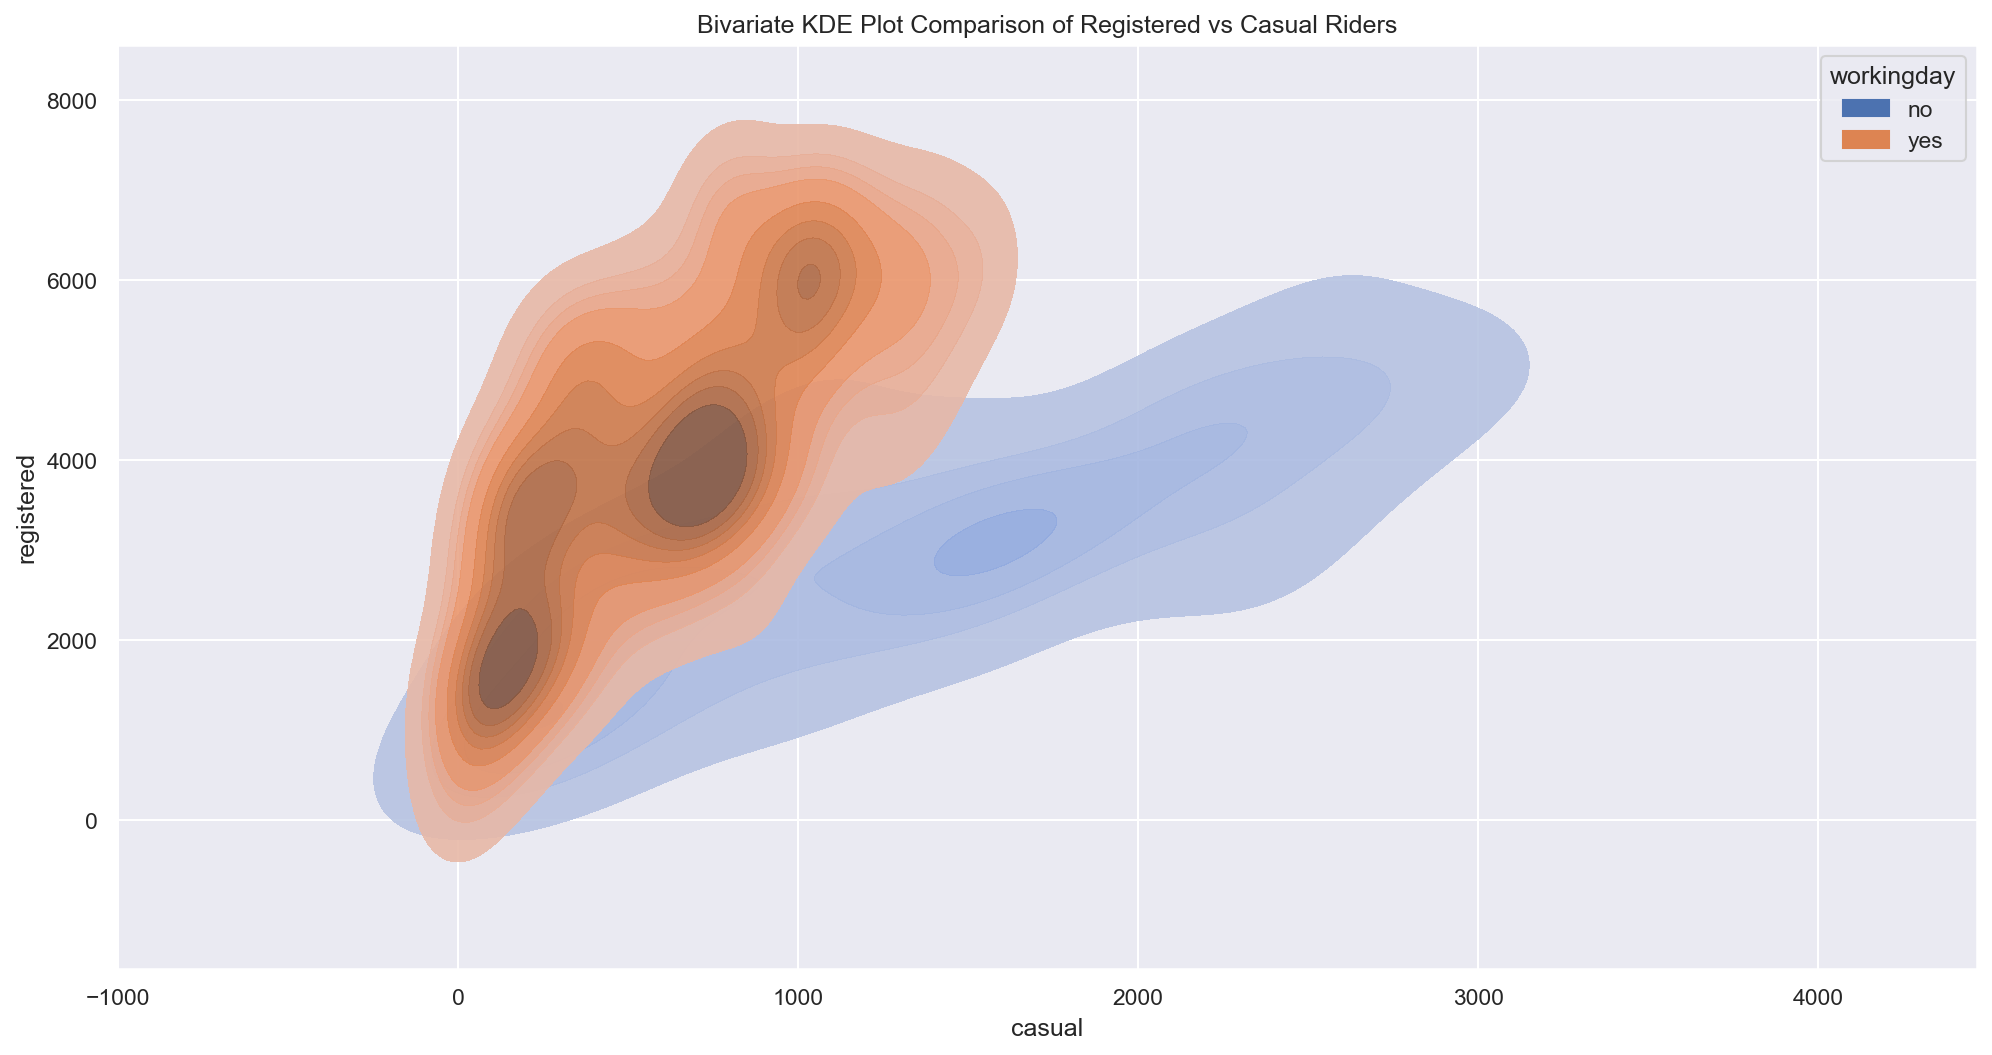

In [75]:
sns.kdeplot(
    data=daily_counts,
    x='casual',
    y='registered',
    hue='workingday',
    fill=True,
    alpha=0.9
)

plt.title('Bivariate KDE Plot Comparison of Registered vs Casual Riders')
plt.show()

<br>

--- 
### 4(b) Contouring the Gradient KDE Plot
The bivariate KDE plot uses **contour lines and color shading** to represent the density of observations across casual and registered rider counts:

- **Contour Lines**: Each line represents a constant density level, similar to elevation lines on a topographic map. Points along the same line have roughly equal density.
- **Color Gradient**: Darker shades indicate areas with higher concentrations of data points, while lighter areas show lower density.
- **Spacing Between Lines**: Tightly packed lines suggest a steep change in density, whereas widely spaced lines indicate a more gradual shift.

This visualization quickly identifies where rider behavior is most common and how sharply it changes across the dataset.


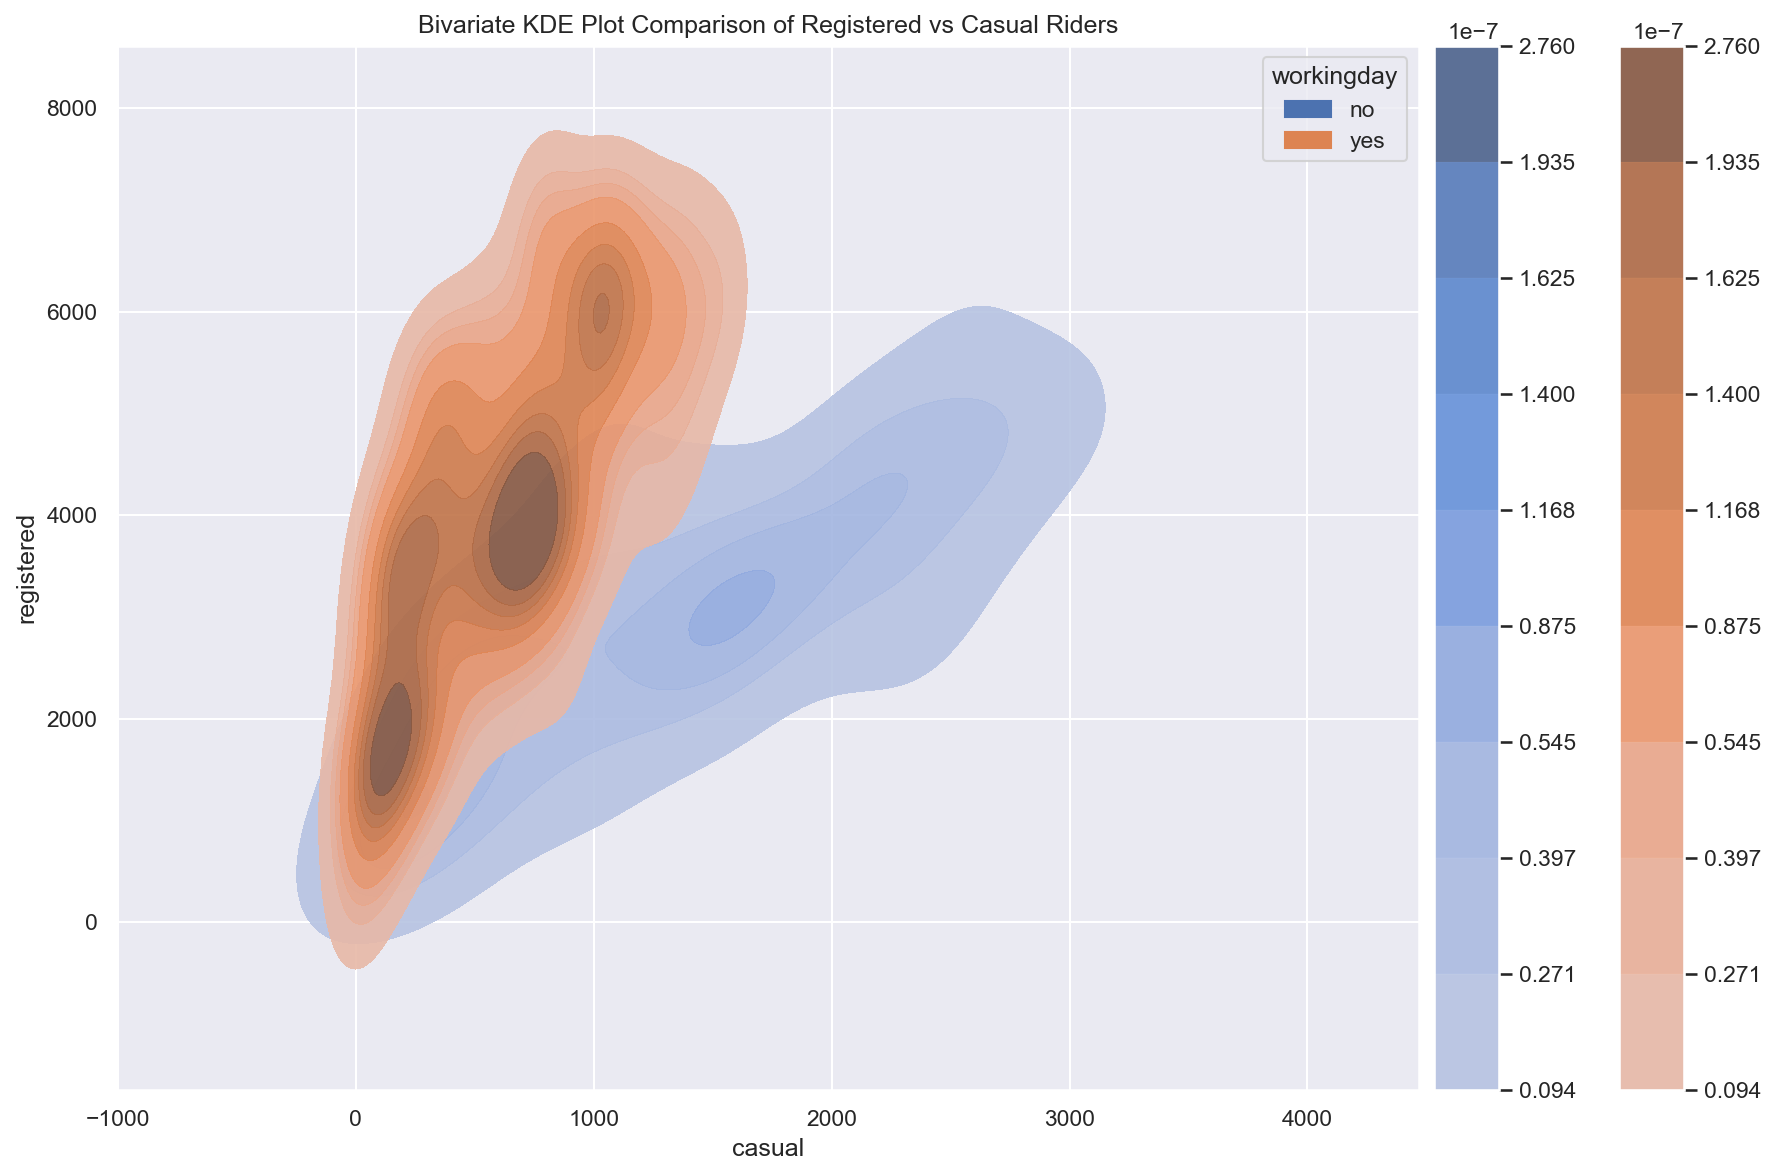

In [95]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and main axis
fig, ax = plt.subplots(figsize=(12, 8))

# KDE plot with hue
kde_plot = sns.kdeplot(
    data=daily_counts,
    x='casual',
    y='registered',
    hue='workingday',
    fill=True,
    alpha=0.9,
    ax=ax
)

# Add colorbar for KDE plot
divider = make_axes_locatable(ax)
# Colorbar for Non-Workday (blue)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cb1 = plt.colorbar(kde_plot.collections[0], cax=cax1)

# Colorbar for Workday (red)
cax2 = divider.append_axes("right", size="5%", pad=0.8)  # Increased pad for more separation
cb2 = plt.colorbar(kde_plot.collections[1], cax=cax2)

# Titles and labels
ax.set_title('Bivariate KDE Plot Comparison of Registered vs Casual Riders')
ax.set_xlabel('casual')
ax.set_ylabel('registered')

plt.tight_layout()
plt.show()

<br>

--- 
### 4(c) Insights from the Contour Plot

Compared to the scatter plot, the contour plot offers clearer insights into data density and overlap:

- The **bottom-left clutter** in the scatter plot only showed a concentration of points without revealing structure.
- **Overlapping categories** were hard to distinguish. Orange workday points obscured the blue non-workday ones.
- In the contour plot, **transparent layers** and shared density lines make it easier to see where patterns diverge or overlap.
- We can now clearly observe that non-working days tend to cluster around higher casual counts with lower registered usage, while working days show denser activity in higher registered rider regions.

This visualization reveals nuanced behavioral differences that the scatter plot obscured.


<hr style="border: 1px solid #fdb515;" />

## 5: Joint Plot
To further explore the relationship between **casual** and **registered** daily rider counts, I created a **joint kernel density plot** using Seaborn’s `jointplot` with `kind="kde"`.

This visualization includes:
- A **main plot** showing the bivariate KDE contours of both variables
- **Marginal plots** (top and right) displaying the univariate KDEs of casual and registered counts, respectively

This combined view allows us to:
- Identify common value ranges for each rider type
- Visualize the joint distribution while also understanding each variable’s individual behavior
- Observe patterns without relying on scatter points, helping reduce clutter

While it’s less suited for comparing conditions like workdays vs. weekends, this plot provides a clean, aggregated look at overall usage trends.

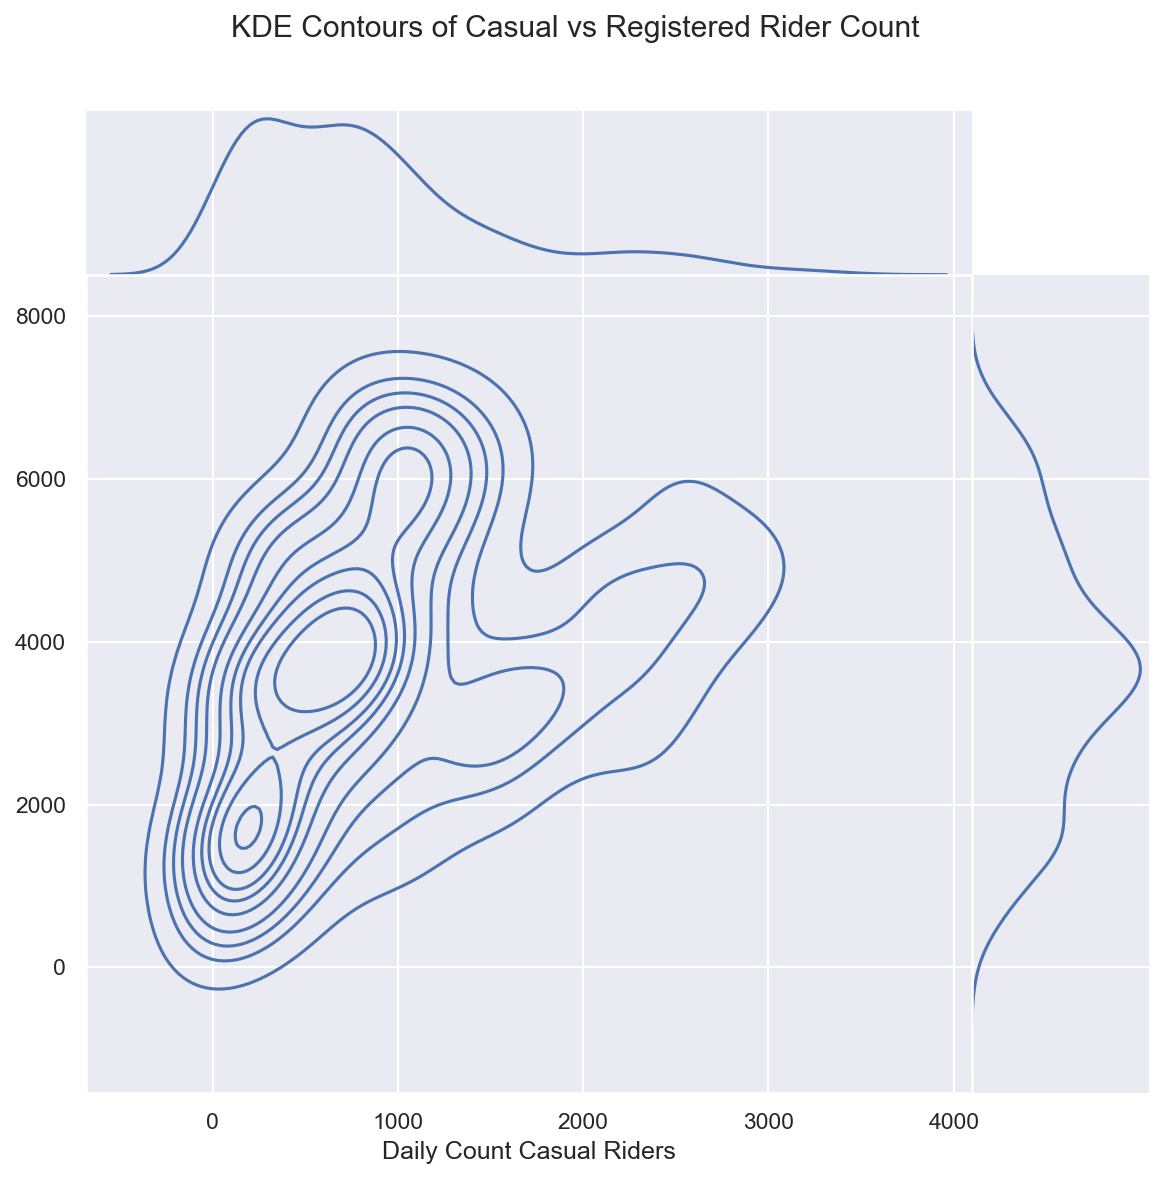

In [37]:
g = sns.jointplot(x = 'casual', y = 'registered', data = daily_counts, kind = 'kde', height=8, space=0)
g.set_axis_labels('Daily Count Casual Riders')
plt.suptitle("KDE Contours of Casual vs Registered Rider Count")
plt.subplots_adjust(top=0.9);

<hr style="border: 1px solid #fdb515;" />

## 6: Understanding Daily Patterns

<br>

--- 

### 6(a) Daily Riding Patterns by Hour
To explore how ridership varies over the course of a day, I plotted the **average number of riders per hour** using the full `bike` DataFrame. The data is stratified by rider type: **casual** and **registered**.

Key features of the plot:
- **X-axis**: Hour of the day (0–23)
- **Y-axis**: Average rider count
- **Lines**: Separate curves for casual and registered users
- **Legend and labels**: Included for clarity

Insights:
- **Registered riders** show clear morning and evening peaks, consistent with commuting behavior.
- **Casual riders** tend to ride later in the day, peaking in the afternoon and early evening.

This diurnal pattern highlights distinct usage behavior between rider types, with implications for resource planning and bike availability across time.
<img src="images/diurnal_bikes.png" width="800px"/>


In [39]:
hourly_means = bike.pivot_table(index='hr', values=['casual', 'registered'], aggfunc='mean')
hourly_means.head()

,casual,registered
hr,,
0,10.158402,43.739669
1,6.504144,26.871547
2,4.772028,18.097902
3,2.715925,9.011478
4,1.253945,5.098996


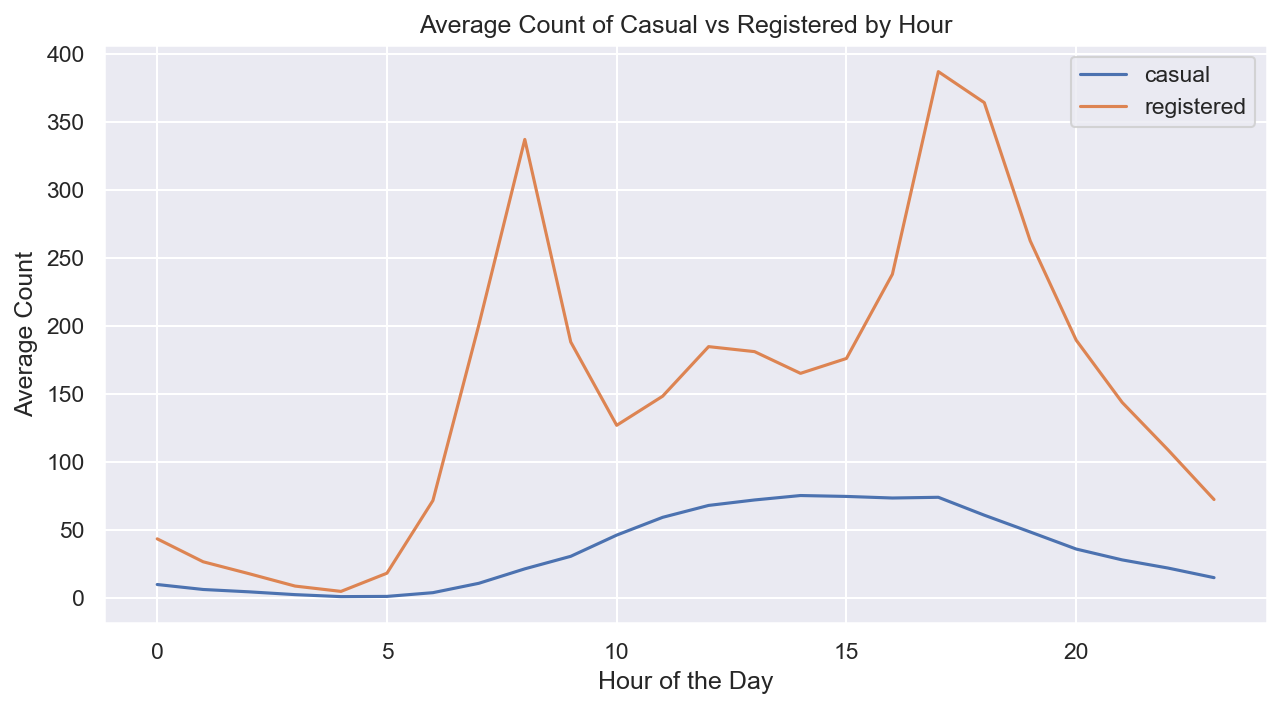

In [40]:
hourly_means = bike.pivot_table(index='hr', values=['casual', 'registered'], aggfunc='mean')
plt.figure(figsize=(10, 5))  # Adjusted figure size for consistent width
sns.lineplot(x = hourly_means.index, y = hourly_means['casual'], label = 'casual')
sns.lineplot(x = hourly_means.index, y = hourly_means['registered'], label = 'registered')

plt.title('Average Count of Casual vs Registered by Hour')
plt.xlabel("Hour of the Day")
plt.ylabel("Average Count")
plt.show()

<br>

--- 
### 6(b) Interpreting Hourly Ridership Trends

From the plot, I observe that **registered riders consistently outnumber casual riders** throughout the day. The registered rider count shows two distinct peaks that align with typical commuting hours: around **8 AM** and **5 to 6 PM**.

This suggests that many registered users rely on the bike system for daily travel to and from work. After the evening commute, ridership for both groups declines sharply, reflecting reduced demand outside of standard activity hours.

Casual rider activity remains lower and peaks later in the day, likely representing recreational or leisure use rather than commuting.


<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## 7: Exploring Ride-Sharing and Weather
Now let's examine how the weather is affecting riders' behavior. First, I look at how the proportion of casual riders changes as the weather changes.

<br>

--- 

### 7(a) Calculating Casual Rider Proportion
Create a new column `prop_casual` in the `bike` `DataFrame` representing the proportion of casual riders out of all riders for each record.

In [41]:
bike['prop_casual'] = bike['casual']/(bike['casual'] + bike['registered'])
bike

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,prop_casual
0,1,2011-01-01,1,0,1,0,no,Sat,no,Clear,0.24,0.2879,0.81,0.0000,3,13,16,0.187500
1,2,2011-01-01,1,0,1,1,no,Sat,no,Clear,0.22,0.2727,0.80,0.0000,8,32,40,0.200000
2,3,2011-01-01,1,0,1,2,no,Sat,no,Clear,0.22,0.2727,0.80,0.0000,5,27,32,0.156250
3,4,2011-01-01,1,0,1,3,no,Sat,no,Clear,0.24,0.2879,0.75,0.0000,3,10,13,0.230769
4,5,2011-01-01,1,0,1,4,no,Sat,no,Clear,0.24,0.2879,0.75,0.0000,0,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,no,Mon,yes,Mist,0.26,0.2576,0.60,0.1642,11,108,119,0.092437
17375,17376,2012-12-31,1,1,12,20,no,Mon,yes,Mist,0.26,0.2576,0.60,0.1642,8,81,89,0.089888
17376,17377,2012-12-31,1,1,12,21,no,Mon,yes,Clear,0.26,0.2576,0.60,0.1642,7,83,90,0.077778
17377,17378,2012-12-31,1,1,12,22,no,Mon,yes,Clear,0.26,0.2727,0.56,0.1343,13,48,61,0.213115


To explore how temperature affects the proportion of casual riders, I created a scatterplot using Seaborn’s `sns.scatterplot`, with **temperature on the x-axis** and **`prop_casual` on the y-axis**. I also added color (`hue`) to represent the **day of the week**.

However, the resulting plot was overly cluttered due to overlapping points and too many color categories. While this plot encodes useful variables, its visual complexity makes it difficult to draw meaningful conclusions without further refinement.

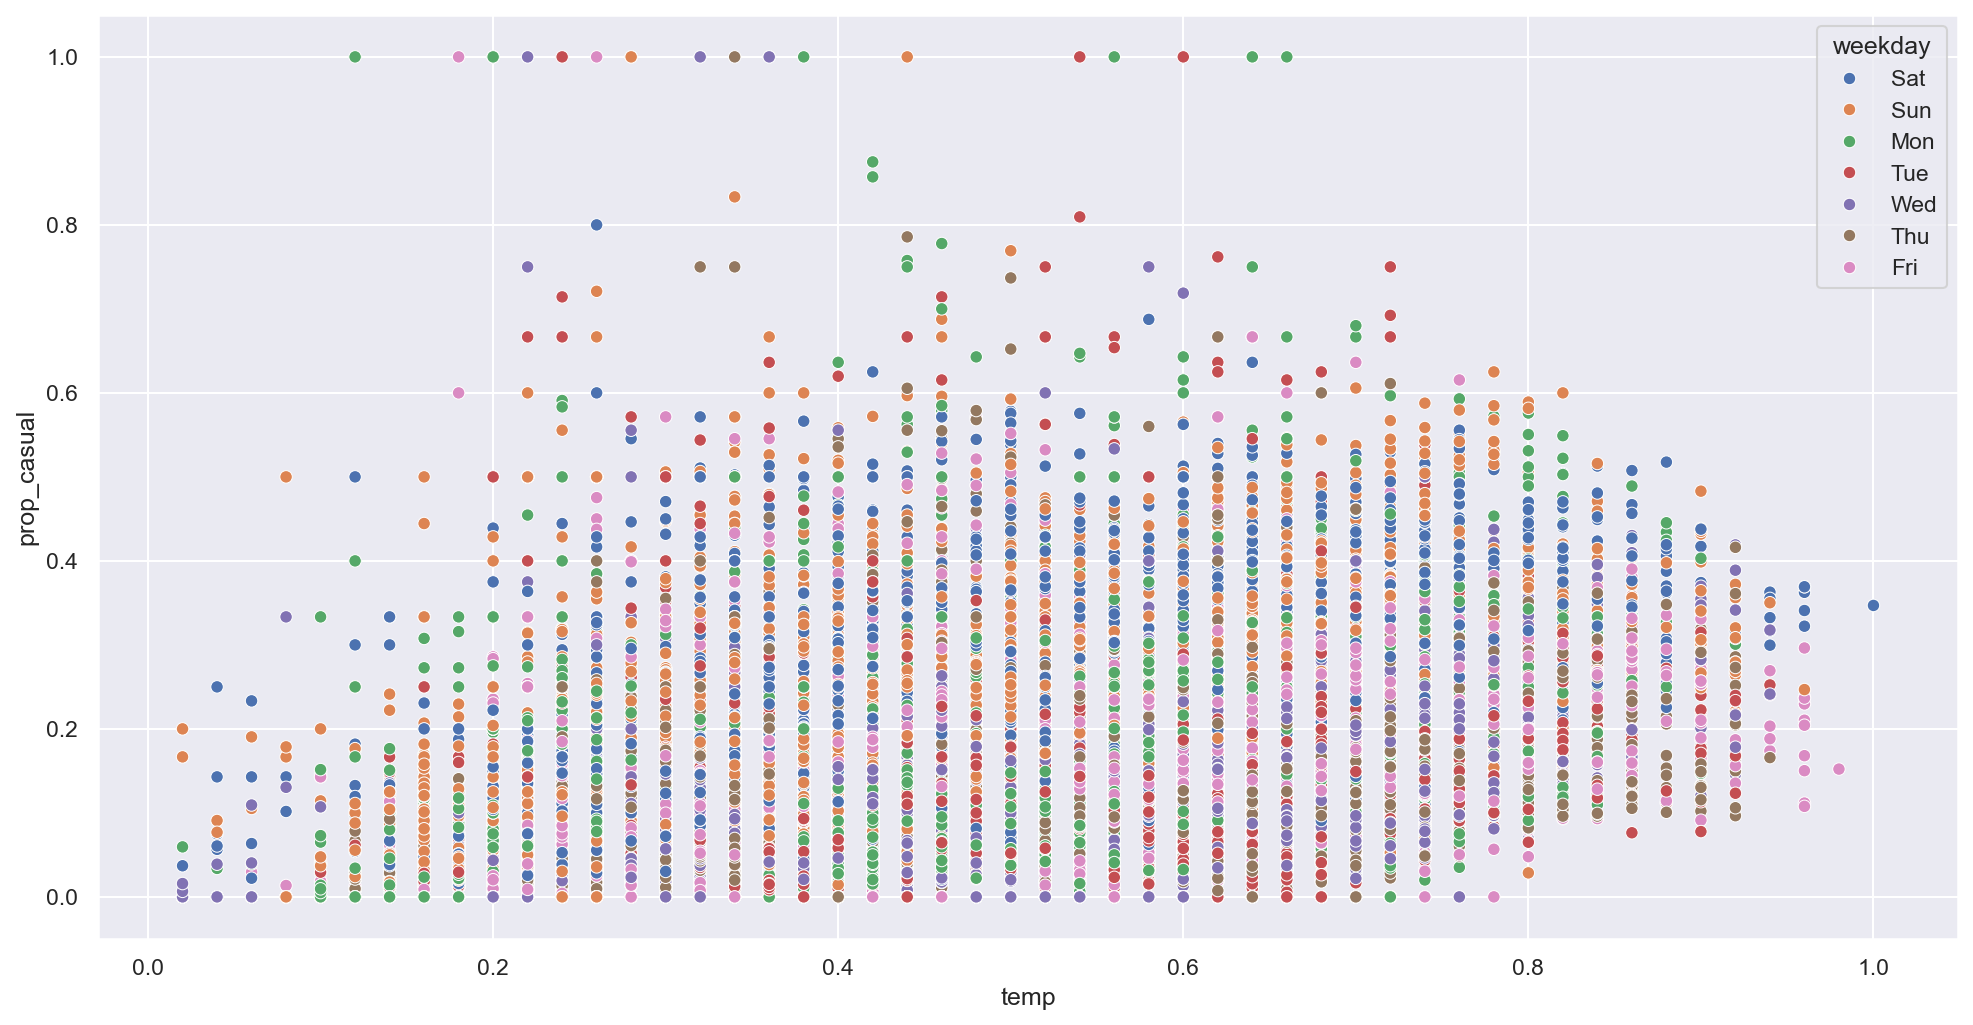

In [97]:
# Plotting the proportion of casual riders against temperature, colored by weekday
plt.figure(figsize=(16, 8))
sns.scatterplot(data=bike, x='temp', y='prop_casual', hue='weekday');

I can attempt linear regression using `sns.lmplot` as shown below, which hints at some relationships between temperature and proportional casual, but the plot is still fairly unconvincing. 

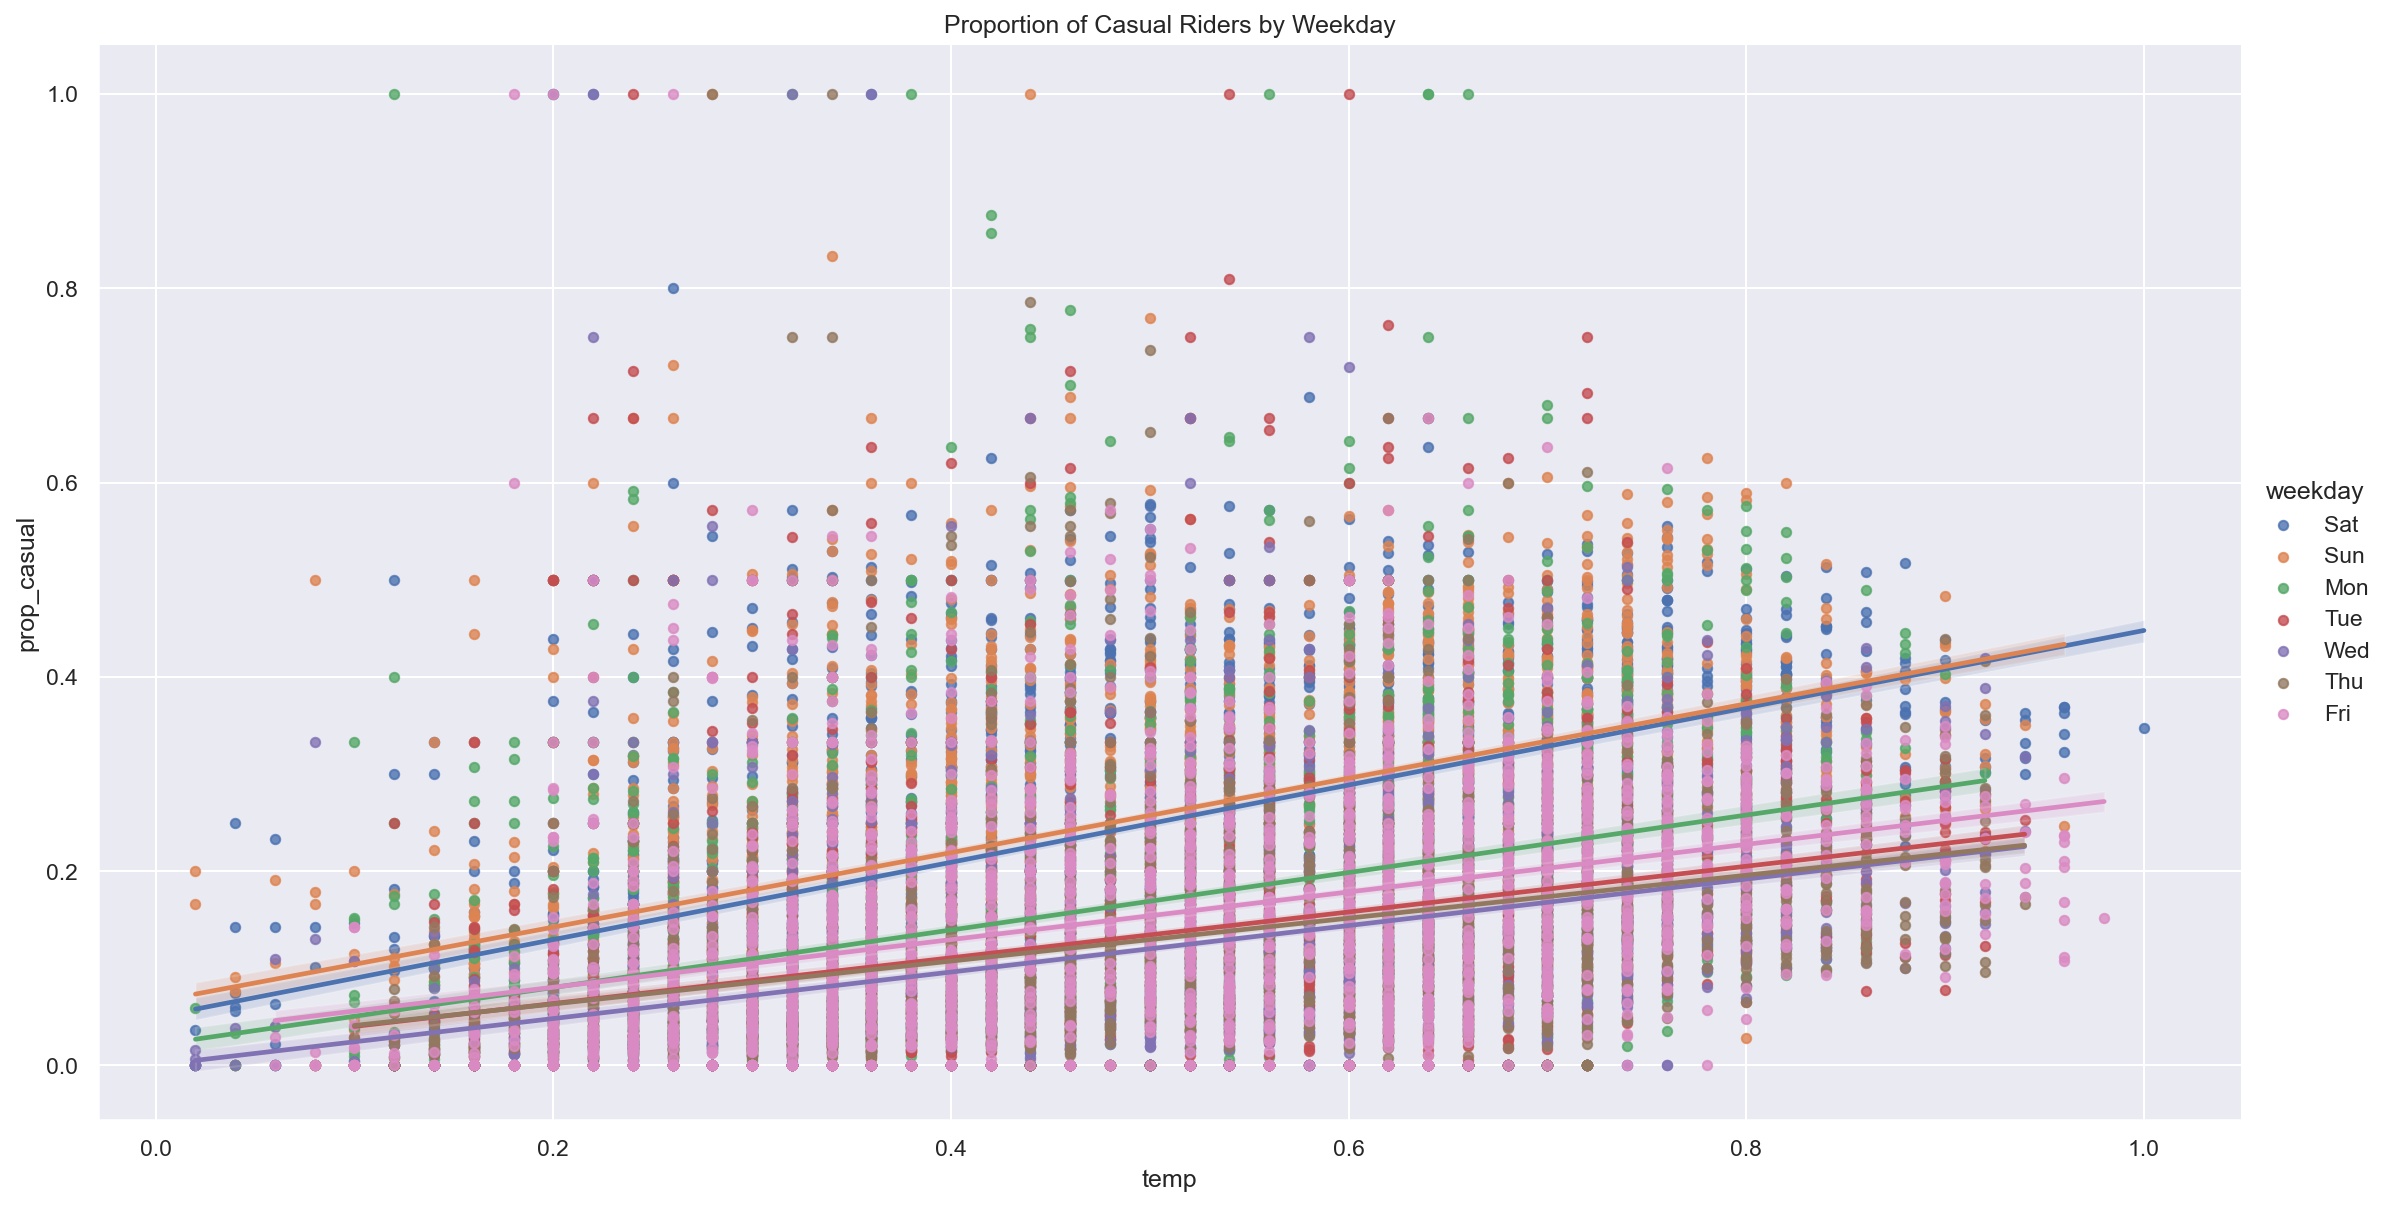

In [98]:
# Linear regression plot
g = sns.lmplot(data=bike, x='temp', y='prop_casual', hue='weekday', scatter_kws={"s": 20}, height=8, aspect=2)
g.fig.set_size_inches(16, 8)
plt.title("Proportion of Casual Riders by Weekday");

### Smoothing the Relationship with LOWESS

To better understand how temperature affects the proportion of casual riders, I applied **Locally Weighted Scatterplot Smoothing (LOWESS)**. This technique fits a smooth curve to the data by computing weighted averages around each x-value, reducing the visual noise from raw scatter points.

The resulting **red LOWESS curve** reveals the underlying trend (how casual ridership proportion changes as temperature increases) without being distorted by overlapping data or day-to-day fluctuations.

Text(0.5, 1.0, 'Lowess Smoothing of Noisy Data')

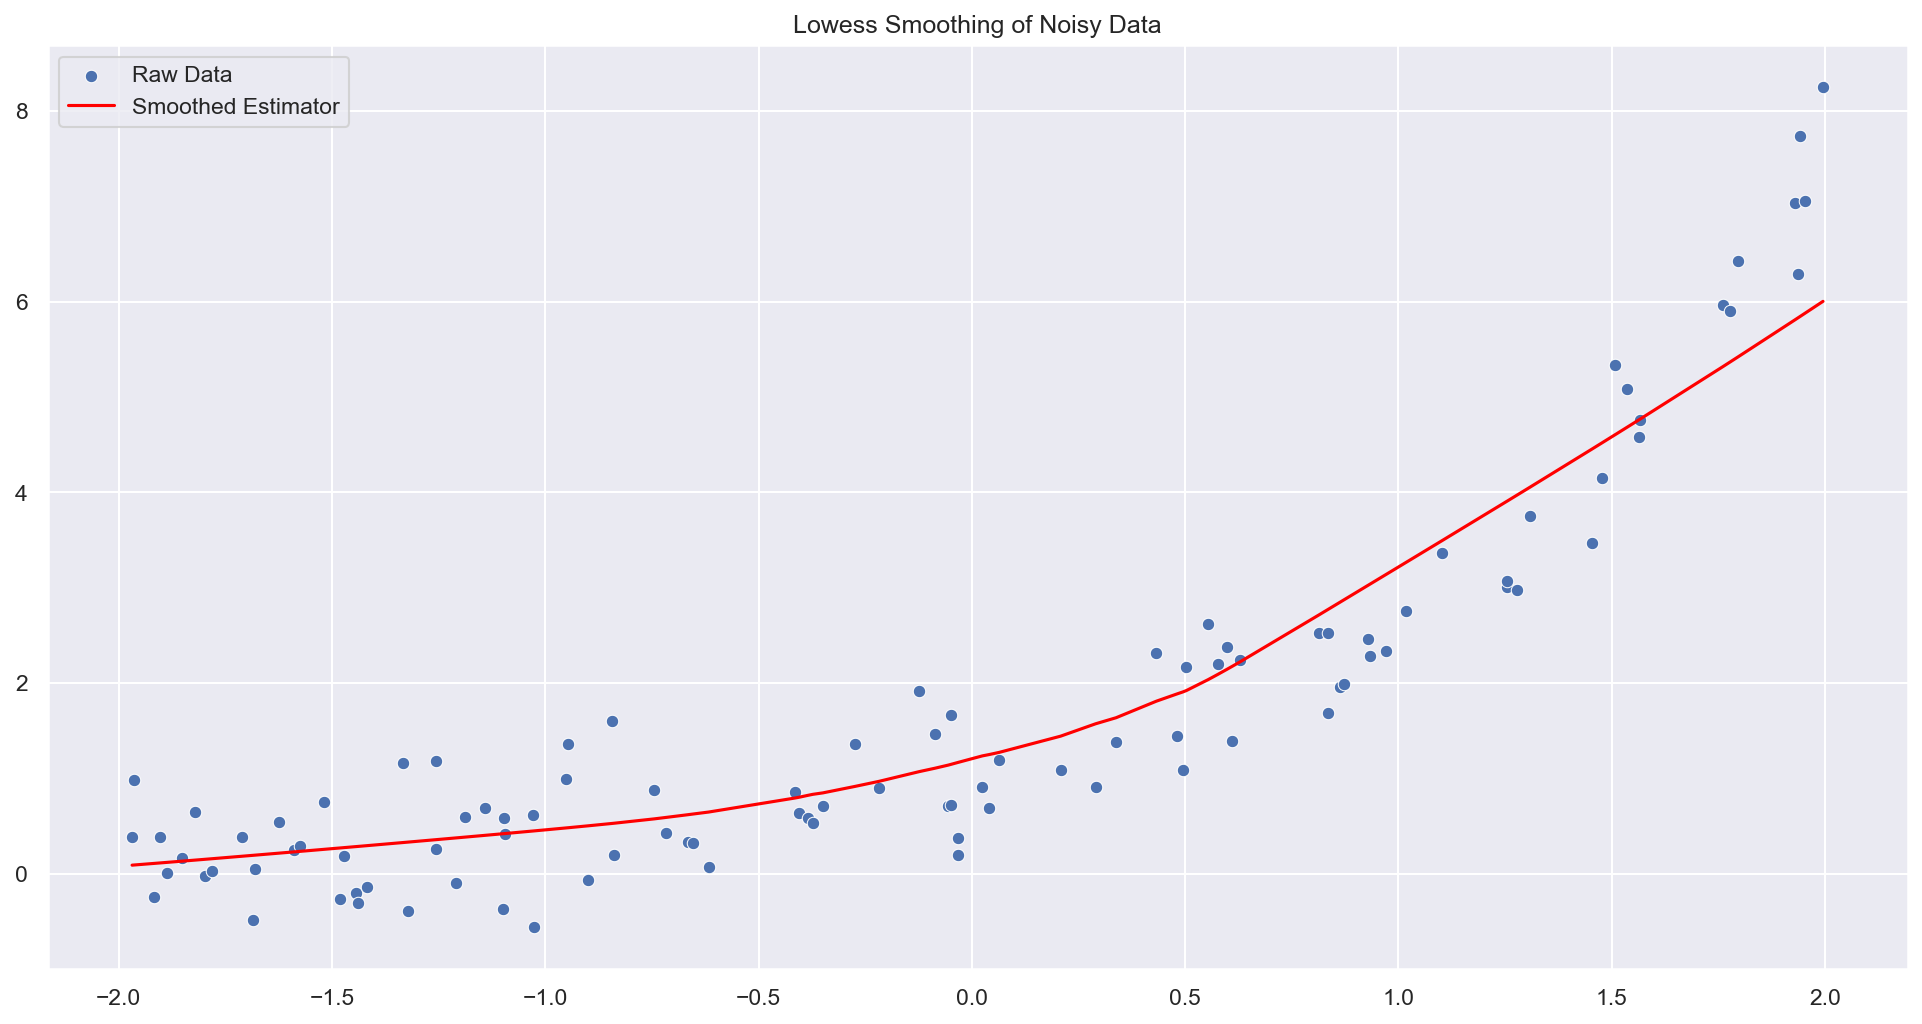

In [101]:
from statsmodels.nonparametric.smoothers_lowess import lowess
# Make noisy data
x_obs = np.sort(np.random.rand(100)*4.0 - 2)
y_obs = np.exp(x_obs) + np.random.randn(100) / 2.0

# Plot a regular scatterplot with our noisy data 
sns.scatterplot(x=x_obs, y=y_obs, label="Raw Data")

# Pass in the noisy data to lowess to generate the smoothed y-values, 
# we want to preserve the relative ordering of the y-values, which is why return_sorted=False
y_smooth = lowess(y_obs, x_obs, return_sorted=False)

# Plot a red line using the smoothed y-values
sns.lineplot(x=x_obs, y=y_smooth, label="Smoothed Estimator", color='red')
plt.legend();
plt.title("Lowess Smoothing of Noisy Data")

<br>

--- 
### 7(b) Smoothed Casual Rider Trends by Day of Week

To determine how temperature affects casual ridership across the week, I plotted **seven LOWESS curves**, one for each **day of the week**, using the `statsmodels.lowess` smoother.

- **X-axis**: Temperature (converted from normalized values to Fahrenheit)
- **Y-axis**: Proportion of casual riders
- **Lines**: One smoothed curve per day, plotted without raw points to avoid clutter

This approach highlights how rider behavior shifts by day. For example, casual ridership tends to increase more with temperature on weekends than weekdays, possibly due to more leisure activity.

Each curve was generated using a loop, filtering data by day, smoothing it with LOWESS, and plotting the result.

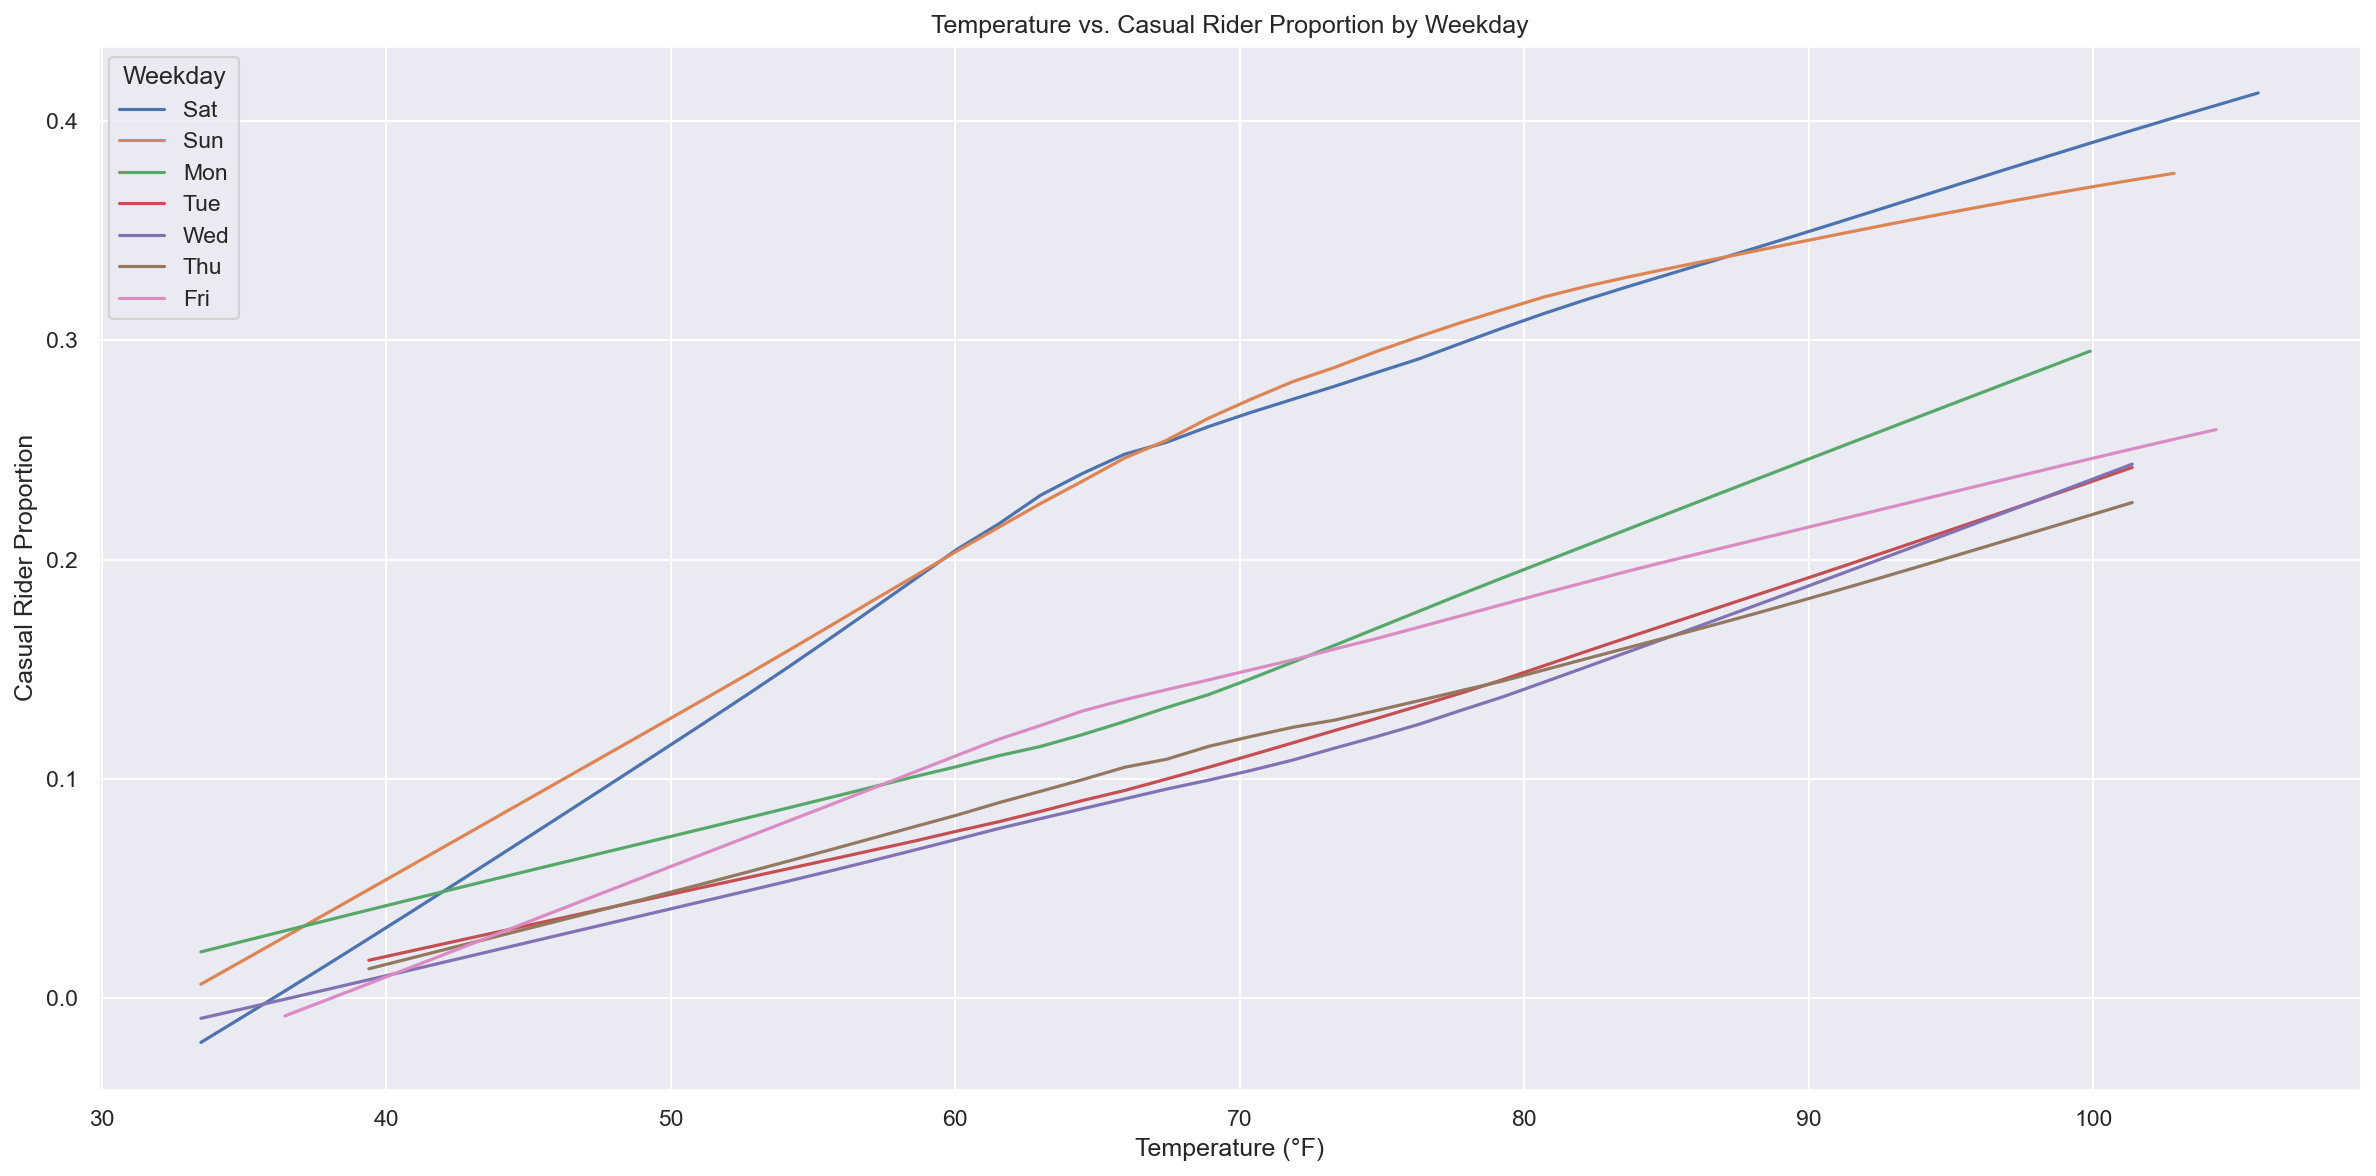

In [102]:
for day in bike['weekday'].unique():
    curr_day = bike[bike['weekday'] == day].copy()
    # Convert temperature from Celsius to Fahrenheit
    curr_day['temp'] = curr_day['temp'] * 41 * 9 / 5 + 32 
    # Apply lowess smoothing to the proportion of casual riders against temperature
    y = lowess(curr_day['prop_casual'], curr_day['temp'], return_sorted = False)
    # Plot the smoothed line for the current day
    sns.lineplot(data = curr_day, x = curr_day['temp'], y = y, label = day)
plt.title("Temperature vs. Casual Rider Proportion by Weekday")
plt.xlabel("Temperature (°F)")
plt.ylabel("Casual Rider Proportion")
plt.legend(title="Weekday")
plt.grid(True)
plt.tight_layout()
plt.show()

<br>

--- 
### 7(c) Interpreting Temperature vs. Casual Rider Proportion
The plot shows that `prop_casual` generally increases with temperature. The **blue and orange lines**, representing **Saturday and Sunday**, have noticeably higher proportions of casual riders than the lines for weekdays.

Weekend curves **peak and taper off** after around 70°F, while weekday lines rise more steadily and linearly. This suggests casual weekend riding is more weather-dependent, while weekday casual usage likely related to commuting is more consistent across temperatures.


<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## 8: Expanding Analysis

<br>

--- 
### 8(a) Assessing Equity in the Bike Dataset

In its current form, the `bike` dataset offers limited insights into equity. While it provides useful temporal and usage trends, it lacks key variables needed to assess who is using the system and whether access is equitable.

To better evaluate equity, I would recommend:

- **Adding a `location` variable** (e.g., latitude/longitude or neighborhood), to analyze geographic access and bike availability across different parts of the city.
- **Including demographic attributes** such as **gender**, **race**, and **socio-economic status**, to identify usage gaps among different population groups.
- **Increasing granularity** by shifting to individual-level trip records, which would allow deeper analysis of user behavior and access patterns.
  
The dataset currently shows that registered riders peak during rush hours, suggesting frequent use by working individuals. However, without demographic or spatial context, we cannot assess whether all communities have equitable access to the bike-sharing service. More detailed data would enable meaningful evaluation and support inclusive transportation planning.



In [104]:
bike.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'prop_casual'],
      dtype='object')

<!-- END QUESTION -->



<br>

--- 
### 8(b) Recommendation for Bike-Sharing Expansion

Bike sharing is [growing in popularity](https://www.bts.gov/newsroom/bike-share-stations-us), and many regions are exploring how it can complement public transit to improve access and reduce congestion. The broader [goals of these efforts](https://www.wired.com/story/americans-falling-in-love-bike-share/) include promoting connectivity, reducing carbon emissions, and fostering community inclusion.

Based on the trends observed in this analysis, I would recommend expanding bike-sharing programs to **urban, commuter-heavy cities** such as **Chicago** or **Philadelphia**. These cities have dense populations, established public transit systems, and growing interest in alternative transportation.

**Reasons for Recommendation:**

1. **Strong commuter usage patterns**  
   The plot of average rider counts by hour (Section 6) showed clear peaks during morning and evening rush hours, especially among registered users. This suggests that bike sharing is a viable option for daily commuting in cities with a strong 9-to-5 workforce.

2. **Weather-sensitive casual usage**  
   From the LOWESS temperature vs. casual rider proportion plot (Section 7), we observed that warmer weather increases casual ridership, particularly on weekends. Cities with **mild to warm climates** would likely see stronger adoption by casual, recreational riders and boost overall utilization.

These patterns indicate that cities with high commuter density, temperate weather, and existing transportation infrastructure are well-suited for bike-sharing expansion



I would like to see how price fluctuates throughout the hours of the day. I presume that there has to be a surge charge for rush hours in order to maximize profit and monitor bike supply. Based on on what I found earlier in the "Temperature vs Casual Rider Proportion by Weekday" plot, I would suggest cities with decently warm weather to implement bike-sharing expansion. It makes even more sense if the cities chosen have a dense working population, because the "Average Count of Casual vs Registered by Hour" plot demonstrated peaks in usage amongst registered riders around rush hours. Other considerations include whether the city has a robust public transportation system with a lack of walkability in the "last mile". This type of city would benefit a lot from a ride-sharing program since it would make the last mile to and from work a lot easier. Another consideration would be the level of car congestion and bike-ability. If a city has heavy car congestion but has well-structured bike lanes, a bike-sharing expansion there makes a lot of sense.

<!-- END QUESTION -->

